# Import libraries 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#from transformers import BertModel, BertTokenizer
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
from sklearn.metrics import adjusted_rand_score
from torch.utils.data import DataLoader
import gensim
import gensim.downloader as gensim_api
from gensim.models import KeyedVectors
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from tqdm import tqdm
import requests
import warnings
import torch
import re

import nltk
#nltk.download()
from nltk.corpus import stopwords



from sklearn import preprocessing



!pip install gdown
import gdown

import gzip

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Fonctions utilitaires 

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = stopwords.words('english')
def clean_text(string : str, punctuations = r'''!()-{}[];:'"\,<>./?@#^%^&*_~''', stop_words = stop_words) -> str:
    """
     A method to clean text
    """
 #Cleaning the urls
    string = re.sub(r'https?://\S+|www\.\S+','',string)

 #Cleaning the html elements
    string = re.sub(r'<.*?>','',string)

 #Cleaning numbers
    string= re.sub(r'[0-9]+','',string)

  #Removing puntuations
    for x in string.lower():
      if x in punctuations:
        string=string.replace(x," ")

  #Converting the text to lower
    string = string.lower()

  #Removing stop words
    string = ' '.join([word for word in string.split() if word not in stop_words])

  #Cleaning the whitespaces
    string = re.sub(r'\s+',' ',string).strip()
    return string


In [ ]:
token_pattern = r"(?u)\b\w\w+\b"
token_pattern = re.compile(token_pattern)

def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)

def accuracy(true_row_labels, predicted_row_labels):
    cm = confusion_matrix(true_row_labels, predicted_row_labels)
    # deprecated: indexes = linear_assignment(_make_cost_m(cm))
    indexes = linear_sum_assignment(_make_cost_m(cm))
    total = 0
    for row, column in zip(*indexes):
        value = cm[row][column]
        total += value

    return (total * 1. / np.sum(cm))

def tokenize_re(text, min_len=2):
    tokens = token_pattern.findall(text)
    return [x for x in tokens if len(x) >= min_len]

def static_document_embeddings(word_embedding_func, docs, tokenizer, n_dims=300):
    """
        Given a set of tokenized sentences, compute the mean vector of w2v vectors for each sentence
    """
    doc_vectors = []
    for doc in docs:
        doc = tokenizer(doc)
        word_vectors = []
        for word in doc:
            vector = word_embedding_func(word)
            if vector is not None:
                word_vectors.append(vector)
        if word_vectors:
            doc_vector = np.array(word_vectors).mean(axis=0)
        else:
            warnings.warn("Zeros returned. Words not in vocabulary \"{}\"".format(doc), Warning)
            doc_vector = np.array([0] * n_dims)
        
        doc_vectors.append(doc_vector)
    return np.array(doc_vectors)


In [ ]:
def eval_clustering_2D(X_reduced, pred_labels, labels):
  plt.figure(figsize = (15, 8))
  nmi = normalized_mutual_info_score(labels,pred_labels )
  plt.suptitle('NMI = ' + str(normalized_mutual_info_score(labels,pred_labels )))
  #plt.suptitle('ACCURACY' + str(accuracy(labels,pred_labels)))
  #plt.suptitle('ACCURACY' + str(adjusted_rand_score(labels,pred_labels)))

  plt.subplot(1, 2, 1)
  plt.title("Predicted_labels")
  plt.scatter(x = X_reduced[:, 0], y = X_reduced[:, 1],c = pred_labels)
  plt.subplot(1, 2, 2)
  plt.title("Labels")
  plt.scatter(x = X_reduced[:, 0], y = X_reduced[:, 1], c = labels)

In [ ]:
def printMetrics(labels, pred_labels):
  print("normalized_mutual_info_score: ",round(normalized_mutual_info_score(pred_labels,labels), 2),"%")
  print("Accuracy: ",round(accuracy(labels,pred_labels),2),"%")
  print("Adjusted Rand Index: ",round(adjusted_rand_score(labels, pred_labels),2),"%")

In [ ]:
from torch.utils.data import DataLoader
import numpy as np
import torch
from tqdm import tqdm


class AutoEncoder(torch.nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super().__init__()
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.embedding_dim)
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(self.embedding_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.input_dim),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def autoencoder(X, embedding_dim, n_epochs=50, batch_size=64, learning_rate=1e-3, weight_decay=1e-8, seed=None, return_model=False):
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

    if seed is not None:
      torch.manual_seed(seed)

    dataloader = DataLoader(dataset=X, batch_size=batch_size, shuffle=True)

    model = AutoEncoder(input_dim=X.shape[1], embedding_dim=embedding_dim)

    if device == 'cuda':
      model.cuda()

    loss_function = torch.nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(),
                                lr=learning_rate,
                                weight_decay=weight_decay)

    losses = []

    model.train()
    for epoch in tqdm(range(n_epochs)):
        for batch in dataloader:
          batch = batch.to(device)
          reconstructed = model(batch)
          
          loss = loss_function(reconstructed, batch)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          losses.append(loss)

    model.eval()
    tensor_X = torch.tensor(X)
    tensor_X = tensor_X.to(device)
    encoded_X = model.encoder(tensor_X)
    encoded_X = encoded_X.detach().cpu().numpy()

    if return_model:
      return encoded_X, model, losses
    else:
      return encoded_X

# Import data 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X = pd.read_csv("/content/drive/MyDrive/classic4.csv")

In [ ]:
X

Unnamed: 0                                               text label
0              0  Computer-Aided Analysis and Design of Informat...  cacm
1              1  Milestones in Cataloging In the case of the pr...  cisi
2              2  childhood psychosis. a description is given of...   med
3              3  neonatal hepatitis or familial neonatal obstru...   med
4              4  Handbook of Comparative Librarianship The firs...  cisi
...          ...                                                ...   ...
7090        7090  throat and nose surgery in patients with const...   med
7091        7091  Computers and Society: A Proposed Course for C...  cacm
7092        7092                 Romberg Integration (Algorithm 60)  cacm
7093        7093  Semantic Evaluation from Left to Right This pa...  cacm
7094        7094       Toward Standards for Handwritten Zero and Oh  cacm

[7095 rows x 3 columns]

In [ ]:
labels = X['label']

In [ ]:
labels.unique()

array(['cacm', 'cisi', 'med', 'cran'], dtype=object)

In [ ]:
labels = pd.factorize(labels)[0]

In [ ]:
labels

array([0, 1, 2, ..., 0, 0, 0])

In [ ]:
texts = X['text'].apply(str)

In [ ]:
texts

0       Computer-Aided Analysis and Design of Informat...
1       Milestones in Cataloging In the case of the pr...
2       childhood psychosis. a description is given of...
3       neonatal hepatitis or familial neonatal obstru...
4       Handbook of Comparative Librarianship The firs...
                              ...                        
7090    throat and nose surgery in patients with const...
7091    Computers and Society: A Proposed Course for C...
7092                   Romberg Integration (Algorithm 60)
7093    Semantic Evaluation from Left to Right This pa...
7094         Toward Standards for Handwritten Zero and Oh
Name: text, Length: 7095, dtype: object

In [ ]:
X.groupby('label').count()

Unnamed: 0  text
label                  
cacm         3204  3204
cisi         1460  1460
cran         1398  1398
med          1033  1033

# Représentations textuelle des données 

#BERT

In [ ]:
def encode_sentences_batch(model, tokenizer, sentences, batch_size=32):
    n_layers = model.config.num_hidden_layers
    tokenized_sentences = [tokenizer.tokenize(sent)[:512] for sent in sentences]
    
    # sort by length
    argsort = np.argsort([len(i) for i in tokenized_sentences])
    sorted_inds = np.argsort(argsort)

    sentences = [sentences[i] for i in argsort]

    # sentences_dataset = BertDataset(sentences)
    data_loader = DataLoader(dataset=sentences,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=4,
                                collate_fn=lambda x: collate_fn(x, tokenizer)
                                )

    embeddings = {k:[] for k in range(n_layers)}

    for _, batch in enumerate(data_loader):
        with torch.no_grad():
            x, mask = batch
            x = x.to(device)

            output = model(x)
            hidden_states = output.hidden_states
            hidden_states = list(hidden_states[1:])

            for ind_layer, layer_embeddings in enumerate(hidden_states):
                # remove padding's zeros
                layer_embeddings = layer_embeddings.cpu() * mask[:, :, None]
                # compute average over tokens
                layer_hidden_state = layer_embeddings.sum(axis=1) / mask.sum(axis=1).unsqueeze(1)


                embeddings[ind_layer].append(layer_hidden_state)

    # put the batches together and sort the documents
    embeddings = [torch.vstack(embeddings[layer_ind])[sorted_inds].numpy() for layer_ind in range(n_layers)]
    
    return embeddings

In [ ]:
def collate_fn(batch_sentences, tokenizer):
    tokenized = tokenizer(batch_sentences, padding=True, truncation=True, max_length=512)
    inds = tokenized['input_ids']
    mask = tokenized['attention_mask']

    inds = torch.tensor(inds)
    mask = torch.tensor(mask)

    return inds, mask

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertModel, BertTokenizer, RobertaModel, RobertaTokenizer
from torch.utils.data import DataLoader
import torch

In [ ]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

In [ ]:
device

'cuda'

In [ ]:
model_name = 'bert-base-cased'
model = BertModel.from_pretrained(model_name, output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained(model_name)

In [ ]:
if device == 'cuda':
  model.cuda()

In [ ]:
X_bert = encode_sentences_batch(model, tokenizer, texts, batch_size=32)

In [ ]:
X_bert[11].shape

(7095, 768)

In [ ]:
X_bert = np.array(X_bert).mean(axis=0)

X_bert.shape

(7095, 768)

## Clustering sur l'espace d'origine

### KMeans

In [ ]:
pred_labels = KMeans(4,random_state=42).fit(X_bert).labels_
printMetrics(labels, pred_labels)

normalized_mutual_info_score:  0.62 %
Accuracy:  0.76 %
Adjusted Rand Index:  0.46 %


### Spectral Clustering

In [ ]:
pred_labels=SpectralClustering(4,affinity='nearest_neighbors',n_neighbors=10,random_state=42).fit(X_bert).labels_
printMetrics(labels, pred_labels)

normalized_mutual_info_score:  0.73 %
Accuracy:  0.77 %
Adjusted Rand Index:  0.52 %


### HDBSCAN

In [ ]:
!pip install hdbscan
import hdbscan

     |████████████████████████████████| 6.4 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311871 sha256=a82292b4d4674af783af93df0f99711d90c6e20a940d4a1579a4a527732086b5
  Stored in directory: /root/.cache/pip/wheels/73/5f/2f/9a259b84003b84847c259779206acecabb25ab56f1506ee72b
Successfully built hdbscan


In [ ]:
from sklearn.preprocessing import StandardScaler
X_bert_sc = StandardScaler().fit_transform(X_bert)
#from sklearn.metrics import pairwise_distances
#distance = pairwise_distances(X_bert, metric='cosine')
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=50, metric='braycurtis').fit(X_bert_sc)

#pred_labels = hdbscan_model.fit(distance.astype('float64')).labels_

pred_labels = hdbscan_model.labels_
printMetrics(labels, pred_labels)

normalized_mutual_info_score:  0.24 %
Accuracy:  0.43 %
Adjusted Rand Index:  0.13 %


In [ ]:
np.unique(pred_labels)

array([-1,  0,  1])

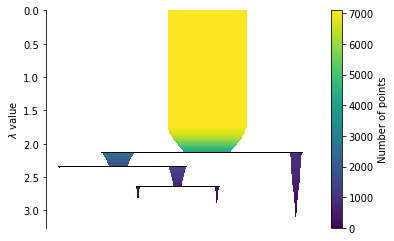

In [ ]:
hdbscan_model.condensed_tree_.plot()

### CAH

In [ ]:
from sklearn.cluster import AgglomerativeClustering

pred_labels = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward').fit(X_bert).labels_
#CAH = AgglomerativeClustering().fit(X_w2v_reduced)
#pred_labels= CAH.labels_
printMetrics(labels, pred_labels)

normalized_mutual_info_score:  0.73 %
Accuracy:  0.77 %
Adjusted Rand Index:  0.52 %


## Approches Tandem

### PCA 

In [ ]:
X_bert_reduced = PCA(n_components=2, whiten=False, random_state=42).fit_transform(X_bert)

#### PCA + Kmeans 

normalized_mutual_info_score:  0.45 %
Accuracy:  0.62 %
Adjusted Rand Index:  0.33 %


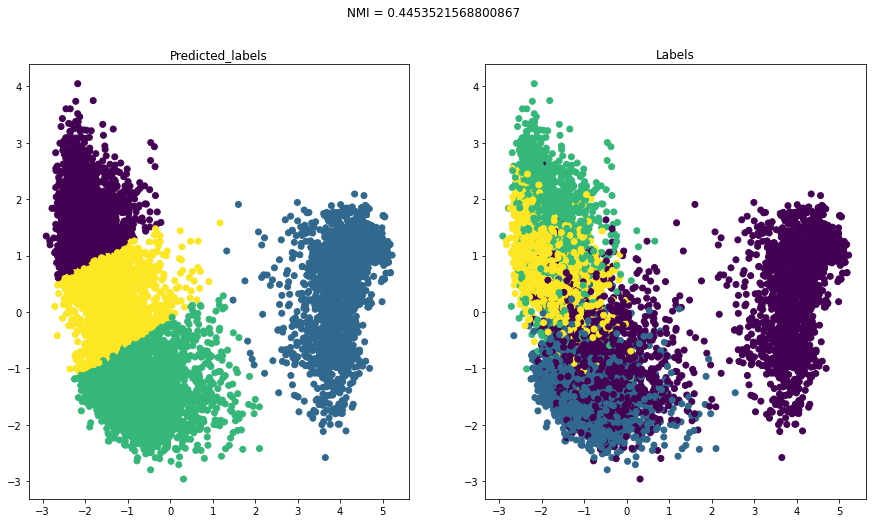

In [ ]:
pred_labels = KMeans(4,random_state=42).fit(X_bert_reduced).labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(X_bert_reduced,pred_labels, labels)

#### PCA + Clustering spectral 

normalized_mutual_info_score:  0.44 %
Accuracy:  0.49 %
Adjusted Rand Index:  0.26 %


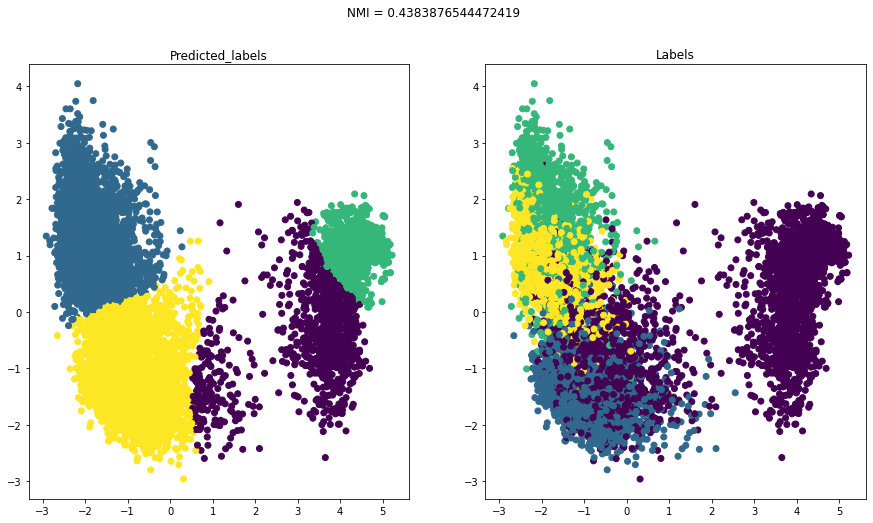

In [ ]:
pred_labels=SpectralClustering(4,affinity='nearest_neighbors',n_neighbors=10,random_state=42).fit(X_bert_reduced).labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(X_bert_reduced,pred_labels, labels)

L'espace réduit obtenu avec la PCA sur BERT n'est pas très interessant, car les clusters sont entremêlés.

#### PCA + HDBSCAN

normalized_mutual_info_score:  0.44 %
Accuracy:  0.58 %
Adjusted Rand Index:  0.33 %


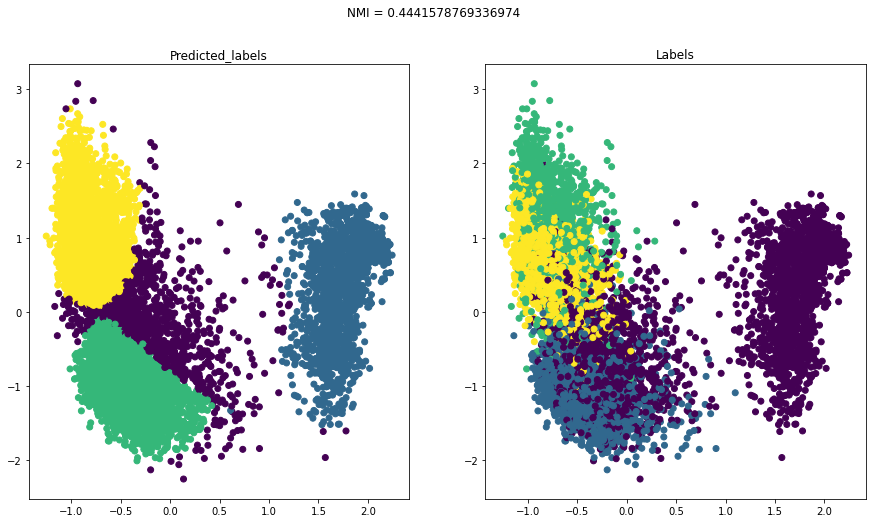

In [ ]:
X_bert_reduced_sc = StandardScaler().fit_transform(X_bert_reduced)
hdbscan_model = hdbscan.HDBSCAN(algorithm= 'best', alpha=1.0, leaf_size=40,min_cluster_size=100, cluster_selection_method='eom', metric='braycurtis').fit(X_bert_reduced_sc)
pred_labels= hdbscan_model.labels_
printMetrics(labels, pred_labels)
eval_clustering_2D(X_bert_reduced_sc,pred_labels, labels)


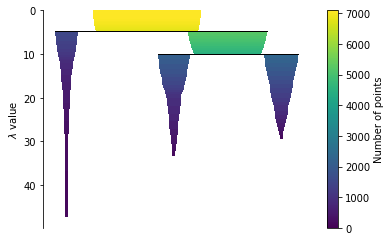

In [ ]:
hdbscan_model.condensed_tree_.plot()

#### PCA + CAH

normalized_mutual_info_score:  0.46 %
Accuracy:  0.63 %
Adjusted Rand Index:  0.34 %


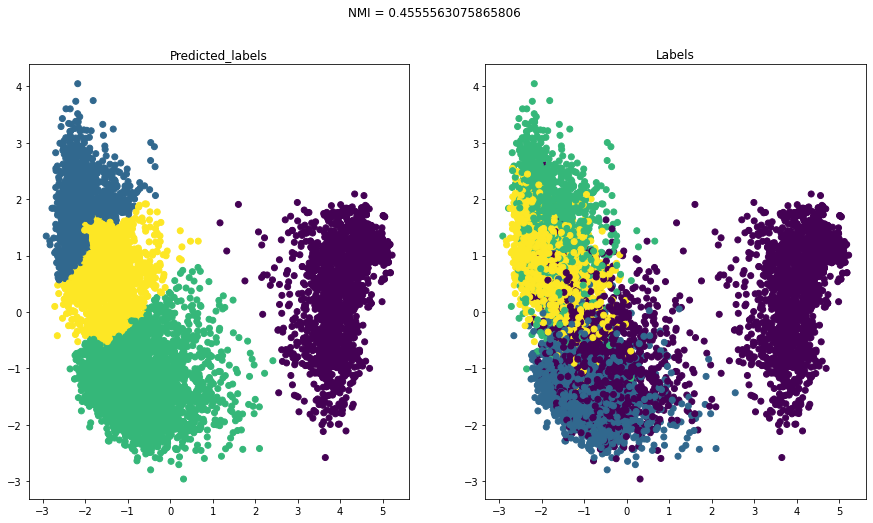

In [ ]:
pred_labels = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward').fit(X_bert_reduced).labels_
printMetrics(labels, pred_labels)
eval_clustering_2D(X_bert_reduced,pred_labels,labels)

### TSNE

In [ ]:
from sklearn.manifold import TSNE
X_bert_reduced = TSNE(n_components=2, random_state=42).fit_transform(X_bert)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
#df = pd.DataFrame({'x':X_bert_reduced[:,0], 'y':X_bert_reduced[:,1], 'cluster':labels})
#sns.relplot(data=df, x='x', y='y', hue='cluster', palette='tab10', kind='scatter')

#### TSNE + Kmeans 

normalized_mutual_info_score:  0.72 %
Accuracy:  0.77 %
Adjusted Rand Index:  0.52 %


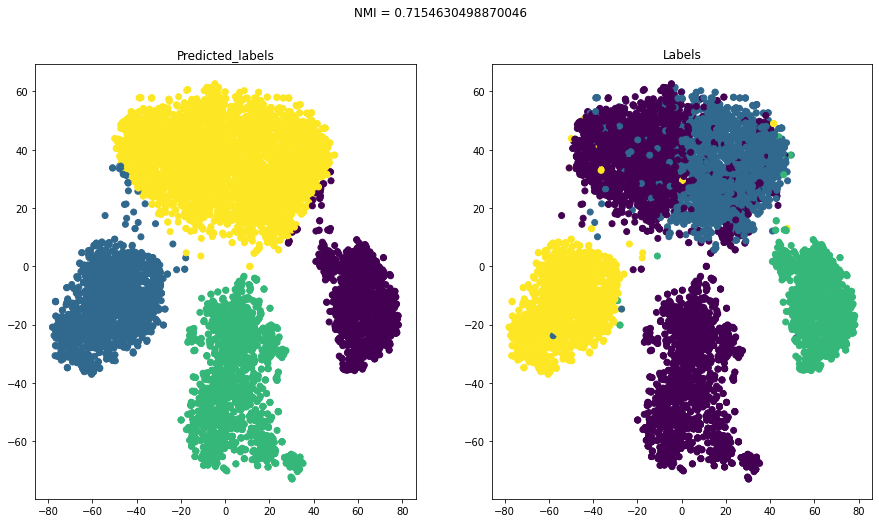

In [ ]:
pred_labels = KMeans(4,random_state=42).fit(X_bert_reduced).labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(X_bert_reduced,pred_labels, labels)

TSNE a bien réussi à séparer les clusters dans l'espace réduit, sauf le cluster violet qui dont une partie se retrouve accolée au cluster bleu. Ce cluster violet correspont au cluster 'cacm' et le bleu au cluster 'cisi'.

#### TSNE + Clustering spectral 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


normalized_mutual_info_score:  0.23 %
Accuracy:  0.42 %
Adjusted Rand Index:  0.01 %


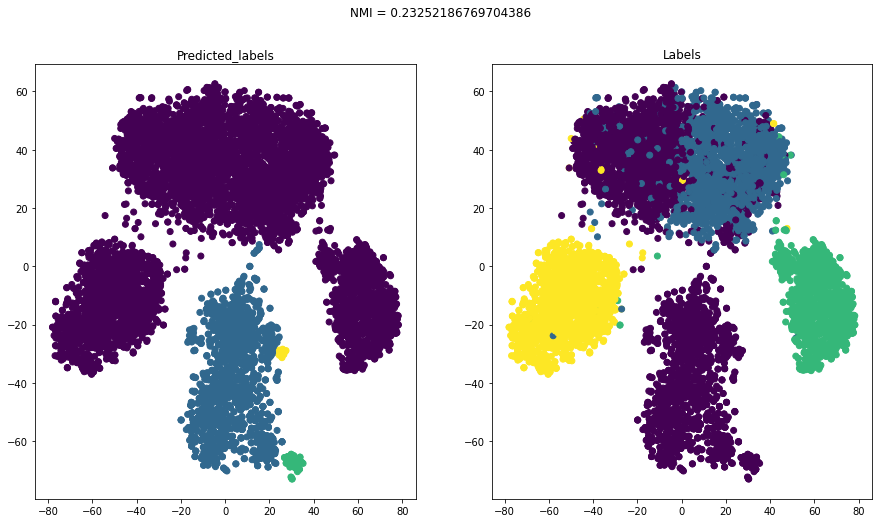

In [ ]:
pred_labels=SpectralClustering(4,affinity='nearest_neighbors',n_neighbors=10,random_state=42).fit(X_bert_reduced).labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(X_bert_reduced,pred_labels, labels)

#### TSNE + HDBSCAN

normalized_mutual_info_score:  0.68 %
Accuracy:  0.72 %
Adjusted Rand Index:  0.49 %


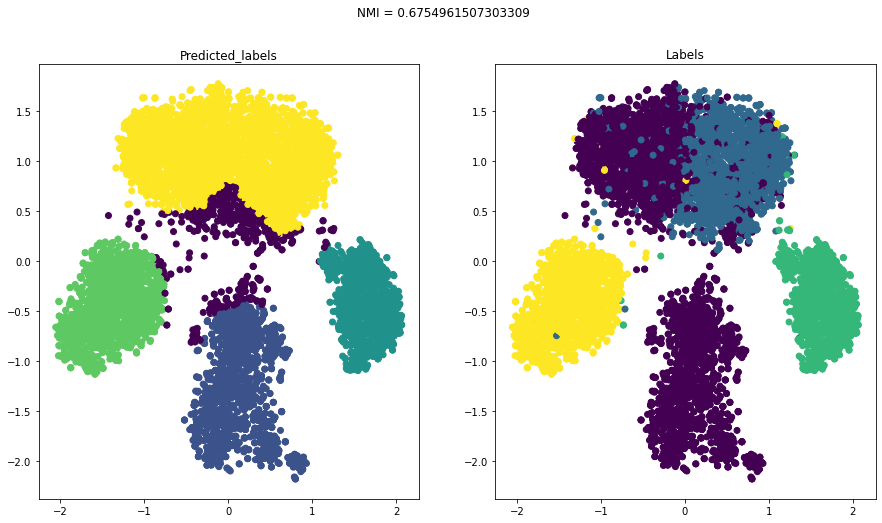

In [ ]:
X_bert_reduced_sc = StandardScaler().fit_transform(X_bert_reduced)
hdbscan_model = hdbscan.HDBSCAN(algorithm= 'best', alpha=1.0, leaf_size=40,min_cluster_size=100, cluster_selection_method='eom', metric='braycurtis').fit(X_bert_reduced_sc)
pred_labels= hdbscan_model.labels_
printMetrics(labels, pred_labels)
eval_clustering_2D(X_bert_reduced_sc,pred_labels, labels)


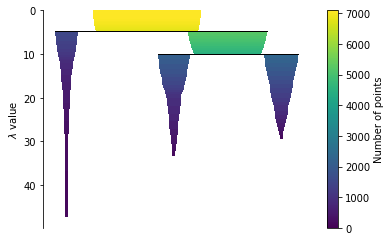

In [ ]:
hdbscan_model.condensed_tree_.plot()

#### TSNE + CAH

normalized_mutual_info_score:  0.74 %
Accuracy:  0.77 %
Adjusted Rand Index:  0.53 %


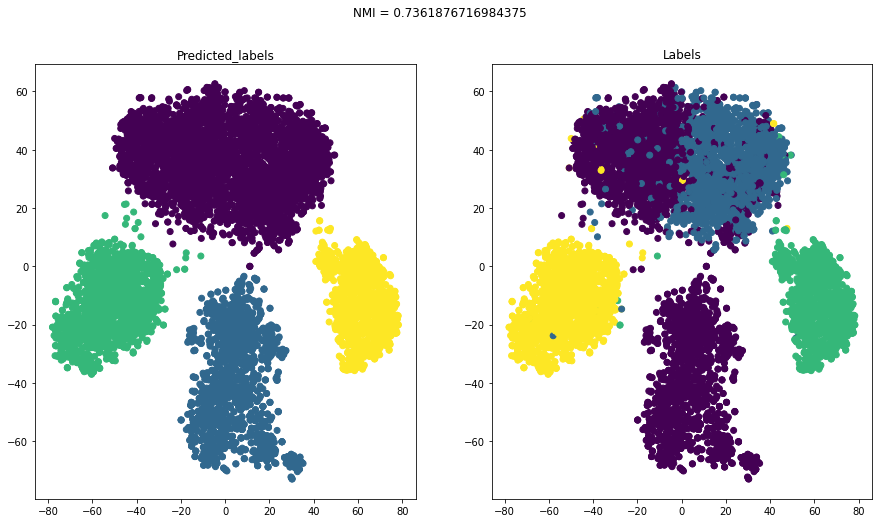

In [ ]:
pred_labels = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward').fit(X_bert_reduced).labels_
printMetrics(labels, pred_labels)
eval_clustering_2D(X_bert_reduced,pred_labels,labels)

### UMAP

In [ ]:
!pip install umap-learn

     |████████████████████████████████| 86 kB 2.8 MB/s 
     |████████████████████████████████| 1.1 MB 36.9 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=7ad6ebfad494648a8dba922d5f0309635db30ca2a04c44e2017cabedb202b7f6
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=556d3a1581ec588419b34b8b26975eda3f2cdfa42f612dd45d3cb8ddb805984d
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


In [ ]:
from umap import UMAP

X_bert_reduced = UMAP(n_components= 2, random_state=42).fit_transform(X_bert)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


#### UMAP + Kmeans 

normalized_mutual_info_score:  0.74 %
Accuracy:  0.77 %
Adjusted Rand Index:  0.53 %


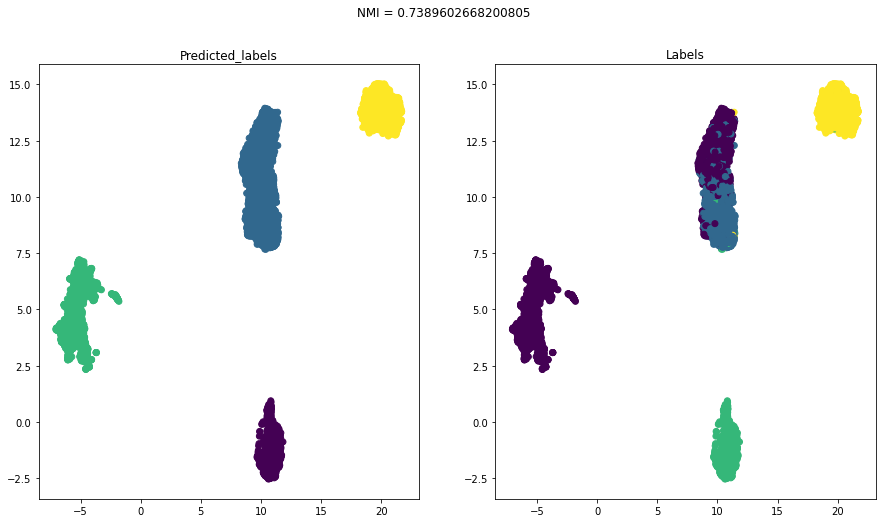

In [ ]:
pred_labels = KMeans(4,random_state=42).fit(X_bert_reduced).labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(X_bert_reduced,pred_labels, labels)

On a le même problème qu'avec TSNE, le cluster cacm se retrouve en partie accolé au cluster cisi. A priori, l'embedding BERT n'arrive pas à séparer correctement ces deux clusters. Pour lui, une partie du cluster cacm a en fait plus de similarité avec le cluster cisi.

#### UMAP + Clustering spectral 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


normalized_mutual_info_score:  0.56 %
Accuracy:  0.73 %
Adjusted Rand Index:  0.41 %


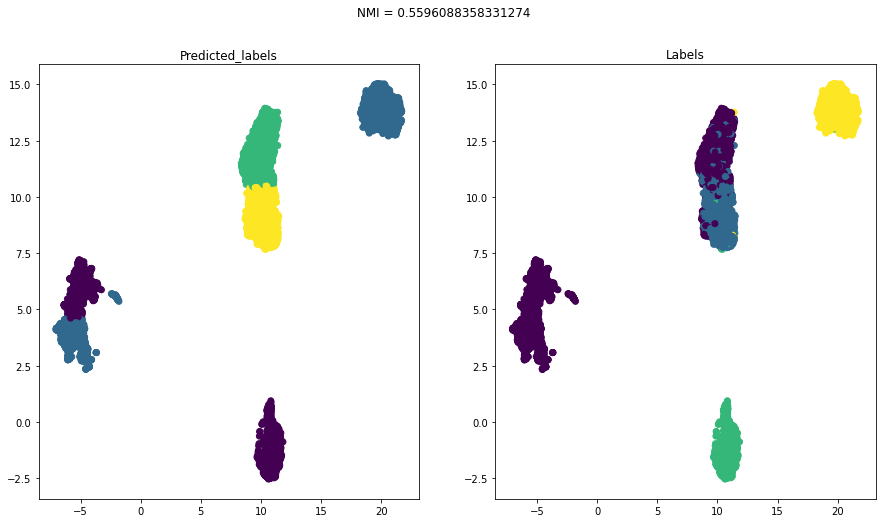

In [ ]:
pred_labels=SpectralClustering(4,affinity='nearest_neighbors',n_neighbors=10,random_state=42).fit(X_bert_reduced).labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(X_bert_reduced,pred_labels, labels)

#### UMAP + HDBSCAN

normalized_mutual_info_score:  0.72 %
Accuracy:  0.76 %
Adjusted Rand Index:  0.52 %


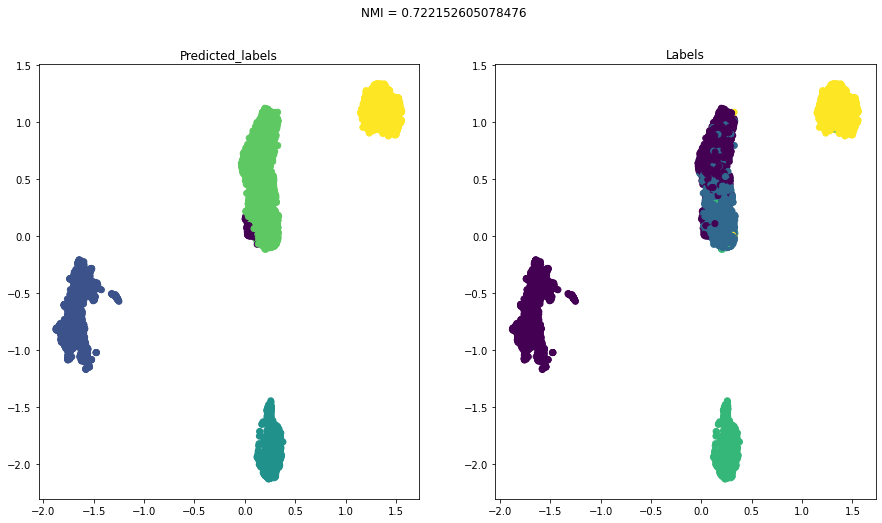

In [ ]:
X_bert_reduced_sc = StandardScaler().fit_transform(X_bert_reduced)
hdbscan_model = hdbscan.HDBSCAN(algorithm= 'best', alpha=1.0, leaf_size=40,min_cluster_size=100, cluster_selection_method='eom', metric='braycurtis').fit(X_bert_reduced_sc)
pred_labels= hdbscan_model.labels_
printMetrics(labels, pred_labels)
eval_clustering_2D(X_bert_reduced_sc,pred_labels, labels)


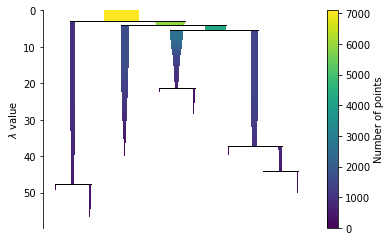

In [ ]:
hdbscan_model.condensed_tree_.plot()

#### UMAP + CAH

normalized_mutual_info_score:  0.74 %
Accuracy:  0.77 %
Adjusted Rand Index:  0.53 %


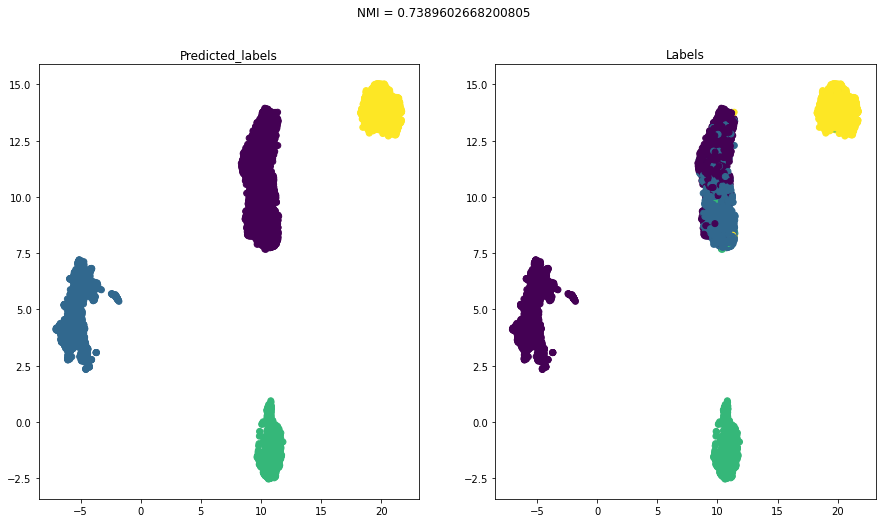

In [ ]:
pred_labels = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward').fit(X_bert_reduced).labels_
printMetrics(labels, pred_labels)
eval_clustering_2D(X_bert_reduced,pred_labels,labels)

### AutoEncoder

In [ ]:
X_bert_reduced = autoencoder(X_bert.astype("float32"), 2, seed=42)

100%|██████████| 50/50 [00:19<00:00,  2.58it/s]


#### AutoEncoder + Kmeans

normalized_mutual_info_score:  0.48 %
Accuracy:  0.54 %
Adjusted Rand Index:  0.28 %


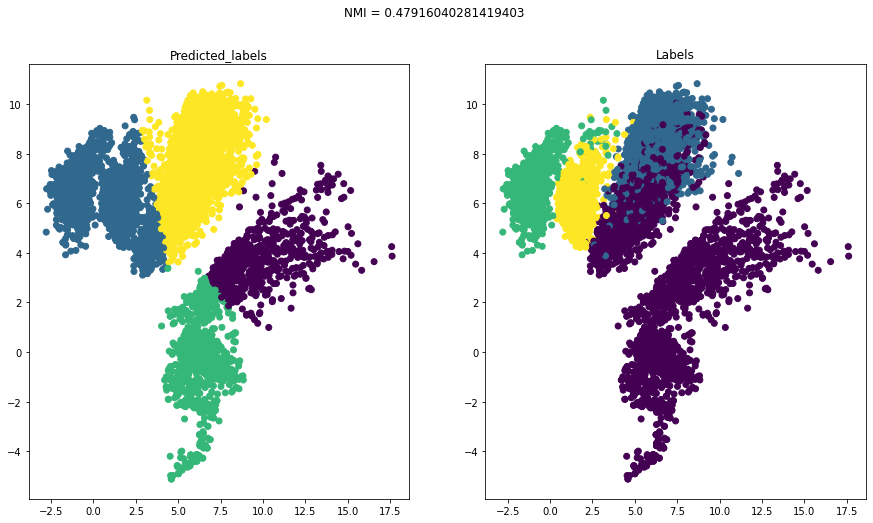

In [ ]:
pred_labels = KMeans(4,random_state=42).fit(X_bert_reduced).labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(X_bert_reduced,pred_labels, labels)

#### AutoEncoder + Clustering spectral 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


normalized_mutual_info_score:  0.55 %
Accuracy:  0.6 %
Adjusted Rand Index:  0.37 %


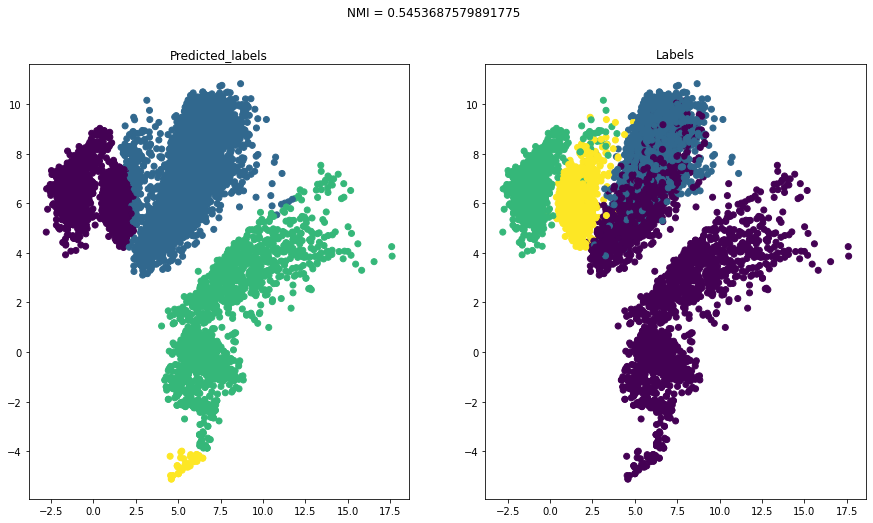

In [ ]:
pred_labels=SpectralClustering(4,affinity='nearest_neighbors',n_neighbors=10,random_state=42).fit(X_bert_reduced).labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(X_bert_reduced,pred_labels, labels)

#### AutoEncoder + HDBSCAN

normalized_mutual_info_score:  0.52 %
Accuracy:  0.57 %
Adjusted Rand Index:  0.35 %


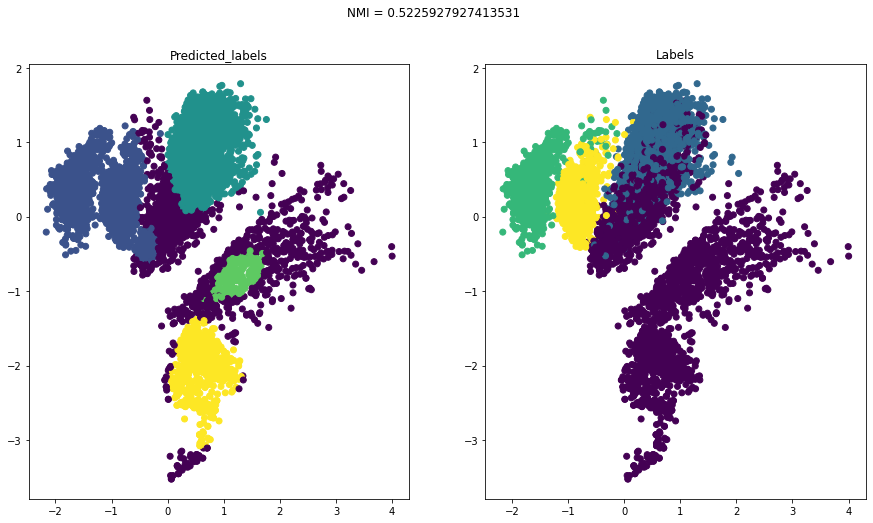

In [ ]:
X_bert_reduced_sc = StandardScaler().fit_transform(X_bert_reduced)
hdbscan_model = hdbscan.HDBSCAN(algorithm= 'best', alpha=1.0, leaf_size=40,min_cluster_size=100, cluster_selection_method='eom', metric='braycurtis').fit(X_bert_reduced_sc)
pred_labels= hdbscan_model.labels_
printMetrics(labels, pred_labels)
eval_clustering_2D(X_bert_reduced_sc,pred_labels, labels)


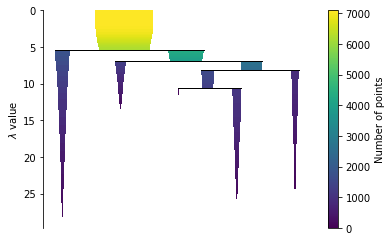

In [ ]:
hdbscan_model.condensed_tree_.plot()

#### AutoEncoder + CAH

normalized_mutual_info_score:  0.58 %
Accuracy:  0.53 %
Adjusted Rand Index:  0.36 %


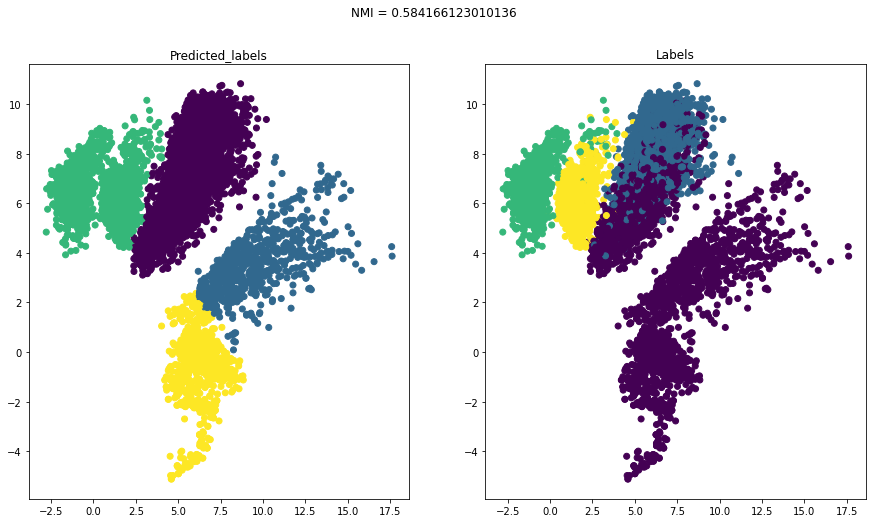

In [ ]:
pred_labels = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward').fit(X_bert_reduced).labels_
printMetrics(labels, pred_labels)
eval_clustering_2D(X_bert_reduced,pred_labels,labels)

### Comparaison des résultats (Tandem)

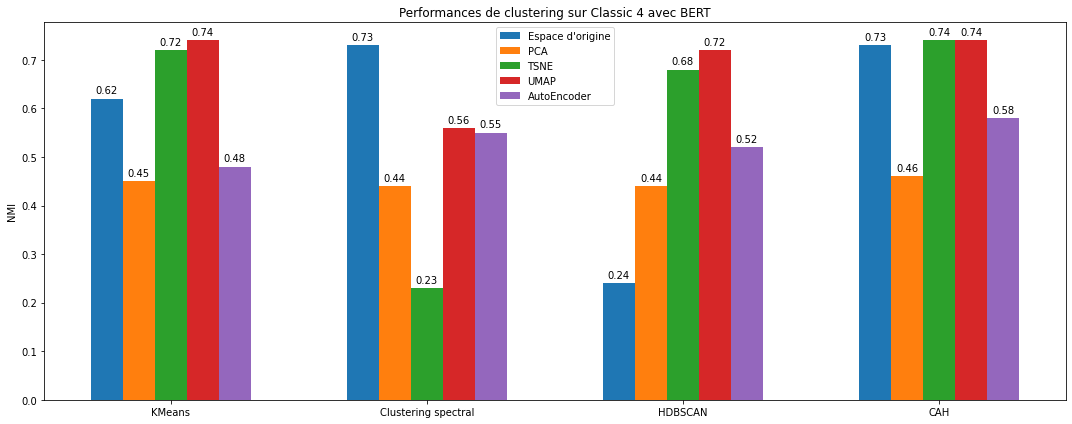

In [ ]:
clust_base = [0.62, 0.73, 0.24, 0.73]
pca_clust = [0.45, 0.44, 0.44, 0.46]
tsne_clust = [0.72, 0.23, 0.68, 0.74]
umap_clust = [0.74, 0.56, 0.72, 0.74]
autoenc_clust = [0.48, 0.55, 0.52, 0.58]
compareNMI(clust_base, pca_clust, tsne_clust, umap_clust, autoenc_clust, "Performances de clustering sur Classic 4 avec BERT")

UMAP reste le meilleur algorithme de réduction de dimension. Pour BERT, les performances de clustering sur l'espace d'origine sont équivalentes à celles sur l'espace réduit, sauf pour HDBSCAN. CAH donne les meilleurs résultats de clustering.

## Méthodes combinées

### Code de DKM et DCN

In [ ]:
import os
import math
import numpy as np
import tensorflow.compat.v1 as tf
from sklearn.cluster import KMeans
from tqdm import tqdm

"""
  Credits:
    This code is based on the implementation provided by Maziar Moradi Fard and Thibaut Thonet
    Available in: https://github.com/MaziarMF/deep-k-means
"""

TF_FLOAT_TYPE = tf.float32

tf.disable_eager_execution()

def fc_layers(input, specs):
    [dimensions, activations, names] = specs
    for dimension, activation, name in zip(dimensions, activations, names):
        input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)
    return input

def autoencoder(input, specs):
    [dimensions, activations, names] = specs
    mid_ind = int(len(dimensions)/2)

    # Encoder
    embedding = fc_layers(input, [dimensions[:mid_ind], activations[:mid_ind], names[:mid_ind]])
    # Decoder
    output = fc_layers(embedding, [dimensions[mid_ind:], activations[mid_ind:], names[mid_ind:]])

    return embedding, output

def f_func(x, y):
    return tf.reduce_sum(tf.square(x - y), axis=1)

def g_func(x, y):
    return tf.reduce_sum(tf.square(x - y), axis=1)

def next_batch(num, data):
    """
    Return a total of `num` random samples.
    """
    indices = np.arange(0, data.shape[0])
    np.random.shuffle(indices)
    indices = indices[:num]
    batch_data = np.asarray([data[i, :] for i in indices])

    return indices, batch_data


#######################################################
############### Deep Clustering Network ###############
#######################################################

class DcnCompGraph(object):
    """Computation graph for the Deep Clustering Network model proposed in:
        Yang, B., Fu, X., Sidiropoulos, N. D., & Hong, M. (2017). Towards K-means-friendly Spaces: Simultaneous Deep
        Learning and Clustering. In ICML '17 (pp. 3861–3870).
    This implementation is inspired by https://github.com/boyangumn/DCN
    """

    def __init__(self, ae_specs, n_clusters, batch_size, n_samples, val_lambda):
        input_size = ae_specs[0][-1]
        embedding_size = ae_specs[0][int((len(ae_specs[0]) - 1) / 2)]

        # Placeholder tensor for input data
        self.input = tf.placeholder(dtype=TF_FLOAT_TYPE, shape=(batch_size, input_size))

        # Auto-encoder loss computations
        self.embedding, self.output = autoencoder(self.input, ae_specs)  # Get the auto-encoder's embedding and output
        rec_error = g_func(self.input, self.output)  # Reconstruction error based on distance g
        self.ae_loss = tf.reduce_mean(rec_error)

        # Clustering loss computations
        ## Tensor for cluster representatives
        minval_rep, maxval_rep = -1, 1
        self.cluster_rep = tf.Variable(tf.random_uniform([n_clusters, embedding_size],
                                                    minval=minval_rep, maxval=maxval_rep,
                                                    dtype=TF_FLOAT_TYPE), name='cluster_rep', dtype=TF_FLOAT_TYPE)

        ## Clustering assignments for all samples in the dataset
        initial_clustering_assign = tf.random_uniform(minval=0, maxval=n_clusters, dtype=tf.int32, shape=[n_samples])
        self.cluster_assign = tf.Variable(initial_clustering_assign, name='cluster_assign', dtype=tf.int32, trainable=False)

        ## Get the cluster representative corresponding to the cluster of each batch sample
        self.indices = tf.placeholder(dtype=tf.int32, shape=batch_size)  # Placeholder for sample indices in current batch
        batch_clust_rep = []
        for j in range(batch_size):
            k = self.cluster_assign[self.indices[j]]  # Clustering assignment for sample j in batch
            batch_clust_rep.append(self.cluster_rep[k, :])
        stack_batch_clust_rep = tf.stack(batch_clust_rep)

        ## Compute the k-means term
        clustering_error = f_func(self.embedding, stack_batch_clust_rep)

        # Compute the full loss combining the reconstruction error and k-means term
        self.ae_loss = tf.reduce_mean(rec_error)
        self.kmeans_loss = tf.reduce_mean(clustering_error)
        self.loss = self.ae_loss + val_lambda * self.kmeans_loss

        # The optimizer is defined to minimize this loss
        optimizer = tf.train.AdamOptimizer()
        self.pretrain_op = optimizer.minimize(self.ae_loss) # Pretrain the autoencoder before starting DCN
        self.train_op = optimizer.minimize(self.loss)

        # As it has been pointed out in the DCN paper, first the weights of the autoencoder shall be trained then the
        # assignments and cluster representatives. So far in the computation graph we have optimized the weights of the
        # autoencoder, now it's the time for the assignments and representatives.

        # Update the clustering assignments
        for j in range(batch_size):
            # Find which cluster representative is the closest to the current batch sample
            new_assign = tf.argmin(f_func(tf.reshape(self.embedding[j, :], (1, embedding_size)), self.cluster_rep),
                                   output_type=tf.int32)
            # Update the clustering assignment
            self.cluster_assign_update = tf.assign(self.cluster_assign[self.indices[j]], new_assign)

        # Update the cluster representatives
        ## Initialize the value of count
        initial_count = tf.constant(100.0, shape=[n_clusters])
        count = tf.Variable(initial_count, name='count', dtype=TF_FLOAT_TYPE, trainable=False)
        ## Update the cluster representatives according to Equation (8) in the DCN paper
        for j in range(batch_size):
            k = self.cluster_assign[self.indices[j]]  # Clustering assignment for sample j in batch
            self.count_update = tf.assign(count[k], count[k] + 1)  # Updated count for cluster assignments
            new_rep = self.cluster_rep[k] - (1 / count[k]) * (self.cluster_rep[k] - self.embedding[j])
            self.cluster_rep_update = tf.assign(self.cluster_rep[k], new_rep)

def DCN(data, n_clusters, n_components, n_pretrain_epochs=50, n_finetuning_epochs=50, lambda_=1.0, batch_size=256, seed=None, cpu=False):
    # Auto-encoder architecture
    input_size = data.shape[1]
    hidden_1_size = 500
    hidden_2_size = 500
    hidden_3_size = 2000
    embedding_size = n_components
    dimensions = [hidden_1_size, hidden_2_size, hidden_3_size, embedding_size, # Encoder layer dimensions
                  hidden_3_size, hidden_2_size, hidden_1_size, input_size] # Decoder layer dimensions
    activations = [tf.nn.relu, tf.nn.relu, tf.nn.relu, None, # Encoder layer activations
                  tf.nn.relu, tf.nn.relu, tf.nn.relu, None] # Decoder layer activations
    names = ['enc_hidden_1', 'enc_hidden_2', 'enc_hidden_3', 'embedding', # Encoder layer names
            'dec_hidden_1', 'dec_hidden_2', 'dec_hidden_3', 'output'] # Decoder layer names

    n_samples = data.shape[0]
    n_batches = int(math.ceil(n_samples / batch_size)) # Number of mini-batches
    pretrain = True # Specify if DKM's autoencoder should be pretrained

    # Hardware specifications
    if cpu:
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Run on CPU instead of GPU if batch_size is small
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.05)

    if seed is not None:
      tf.reset_default_graph()
      tf.set_random_seed(seed)
      np.random.seed(seed)

    cg = DcnCompGraph([dimensions, activations, names], n_clusters, batch_size, n_samples,
                      lambda_)

    # Run the computation graph
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        # Initialization
        init = tf.global_variables_initializer()
        sess.run(init)

        # Pretrain if specified
        if pretrain:
            print("Starting autoencoder pretraining...")

            # Variables to save pretraining tensor content
            embeddings = np.zeros((n_samples, embedding_size), dtype=float)

            # First, pretrain the autoencoder
            ## Loop over epochs
            for _ in tqdm(range(n_pretrain_epochs)):

                # Loop over the samples
                for _ in range(n_batches):
                    # Fetch a random data batch of the specified size
                    indices_, data_batch = next_batch(batch_size, data)

                    # Run the computation graph until pretrain_op (only on autoencoder) on the data batch
                    _, embedding_, ae_loss_ = sess.run((cg.pretrain_op, cg.embedding, cg.ae_loss),
                                                       feed_dict={cg.input: data_batch})

                    # Save the embeddings for batch samples
                    for j in range(len(indices_)):
                        embeddings[indices_[j], :] = embedding_[j, :]

            # Second, run k-means++ on the pretrained embeddings
            print("Running k-means on the learned embeddings...")
            kmeans_model = KMeans(n_clusters=n_clusters, init="k-means++").fit(embeddings)

            # The cluster centers are used to initialize the cluster representatives in DCN
            sess.run(tf.assign(cg.cluster_rep, kmeans_model.cluster_centers_))

            # The clustering assignments are used to initialize the clustering assignments in DCN
            sess.run(tf.assign(cg.cluster_assign, kmeans_model.labels_))

        # Train the full DCN model
        print("Starting DCN training...")
        ## Loop over epochs
        for epoch in tqdm(range(n_finetuning_epochs)):
            # print("Training step: epoch {}".format(epoch))

            # Loop over the samples
            for _ in range(n_batches):
                # Fetch a random data batch of the specified size
                indices_, data_batch = next_batch(batch_size, data)

                # Run the computation graph on the data batch
                _, _, _, _, loss_, cluster_assign_, ae_loss_, kmeans_loss_ =\
                    sess.run((cg.train_op, cg.cluster_assign_update, cg.count_update, cg.cluster_rep_update, cg.loss,
                              cg.cluster_assign, cg.ae_loss, cg.kmeans_loss),
                             feed_dict={cg.input: data_batch, cg.indices: indices_})
        
        embeddings = np.zeros((n_samples, embedding_size), dtype=float)
        for _ in range(n_batches):
            # Fetch a random data batch of the specified size
            indices_, data_batch = next_batch(batch_size, data)

            # Run the computation graph on the data batch
            _, _, embeddings_, _, _, loss_, cluster_assign_, ae_loss_, kmeans_loss_ =\
                sess.run((cg.train_op, cg.cluster_assign_update, cg.embedding, cg.count_update, cg.cluster_rep_update, cg.loss,
                          cg.cluster_assign, cg.ae_loss, cg.kmeans_loss),
                          feed_dict={cg.input: data_batch, cg.indices: indices_})

            for j in range(len(indices_)):
                embeddings[indices_[j], :] = embeddings_[j, :]
                
    return embeddings, cluster_assign_


#######################################################
##################### Deep K-means ####################
#######################################################

class DkmCompGraph(object):
    """Computation graph for Deep K-Means
    """

    def __init__(self, ae_specs, n_clusters, val_lambda):
        input_size = ae_specs[0][-1]
        embedding_size = ae_specs[0][int((len(ae_specs[0])-1)/2)]

        # Placeholder tensor for input data
        self.input = tf.placeholder(dtype=TF_FLOAT_TYPE, shape=(None, input_size))

        # Auto-encoder loss computations
        self.embedding, self.output = autoencoder(self.input, ae_specs)  # Get the auto-encoder's embedding and output
        rec_error = g_func(self.input, self.output)  # Reconstruction error based on distance g

        # k-Means loss computations
        ## Tensor for cluster representatives
        minval_rep, maxval_rep = -1, 1
        self.cluster_rep = tf.Variable(tf.random_uniform([n_clusters, embedding_size],
                                                    minval=minval_rep, maxval=maxval_rep,
                                                    dtype=TF_FLOAT_TYPE), name='cluster_rep', dtype=TF_FLOAT_TYPE)

        ## First, compute the distance f between the embedding and each cluster representative
        list_dist = []
        for i in range(0, n_clusters):
            dist = f_func(self.embedding, tf.reshape(self.cluster_rep[i, :], (1, embedding_size)))
            list_dist.append(dist)
        self.stack_dist = tf.stack(list_dist)

        ## Second, find the minimum squared distance for softmax normalization
        min_dist = tf.reduce_min(list_dist, axis=0)

        ## Third, compute exponentials shifted with min_dist to avoid underflow (0/0) issues in softmaxes
        self.alpha = tf.placeholder(dtype=TF_FLOAT_TYPE, shape=())  # Placeholder tensor for alpha
        list_exp = []
        for i in range(n_clusters):
            exp = tf.exp(-self.alpha * (self.stack_dist[i] - min_dist))
            list_exp.append(exp)
        stack_exp = tf.stack(list_exp)
        sum_exponentials = tf.reduce_sum(stack_exp, axis=0)

        ## Fourth, compute softmaxes and the embedding/representative distances weighted by softmax
        list_softmax = []
        list_weighted_dist = []
        for j in range(n_clusters):
            softmax = stack_exp[j] / sum_exponentials
            weighted_dist = self.stack_dist[j] * softmax
            list_softmax.append(softmax)
            list_weighted_dist.append(weighted_dist)
        stack_weighted_dist = tf.stack(list_weighted_dist)

        # Compute the full loss combining the reconstruction error and k-means term
        self.ae_loss = tf.reduce_mean(rec_error)
        self.kmeans_loss = tf.reduce_mean(tf.reduce_sum(stack_weighted_dist, axis=0))
        self.loss = self.ae_loss + val_lambda * self.kmeans_loss

        # The optimizer is defined to minimize this loss
        optimizer = tf.train.AdamOptimizer()
        self.pretrain_op = optimizer.minimize(self.ae_loss) # Pretrain the autoencoder before starting DKM
        self.train_op = optimizer.minimize(self.loss) # Train the whole DKM model

def DKM(data, n_clusters, n_components, n_pretrain_epochs=50, n_finetuning_epochs=5, lambda_=1.0, batch_size=256, seed=None, cpu=False):
    """
        The final number of finetuning epochs is n_finetuning_epochs * 20 if pretrain and n_finetuning_epochs * 40 if annealing
    """
    # Auto-encoder architecture
    input_size = data.shape[1]
    hidden_1_size = 500
    hidden_2_size = 500
    hidden_3_size = 2000
    embedding_size = n_components
    dimensions = [hidden_1_size, hidden_2_size, hidden_3_size, embedding_size, # Encoder layer dimensions
                  hidden_3_size, hidden_2_size, hidden_1_size, input_size] # Decoder layer dimensions
    activations = [tf.nn.relu, tf.nn.relu, tf.nn.relu, None, # Encoder layer activations
                  tf.nn.relu, tf.nn.relu, tf.nn.relu, None] # Decoder layer activations
    names = ['enc_hidden_1', 'enc_hidden_2', 'enc_hidden_3', 'embedding', # Encoder layer names
            'dec_hidden_1', 'dec_hidden_2', 'dec_hidden_3', 'output'] # Decoder layer names

    n_samples = data.shape[0]
    n_batches = int(math.ceil(n_samples / batch_size)) # Number of mini-batches
    pretrain = True # Specify if DKM's autoencoder should be pretrained
    annealing = False # Specify if annealing should be used

    # Define the alpha scheme depending on if the approach includes annealing/pretraining
    if annealing and not pretrain:
        constant_value = 1  # specs.embedding_size # Used to modify the range of the alpha scheme
        max_n = 40  # Number of alpha values to consider
        alphas = np.zeros(max_n, dtype=float)
        alphas[0] = 0.1
        for i in range(1, max_n):
            alphas[i] = (2 ** (1 / (np.log(i + 1)) ** 2)) * alphas[i - 1]
        alphas = alphas / constant_value
    elif not annealing and pretrain:
        constant_value = 1  # specs.embedding_size # Used to modify the range of the alpha scheme
        max_n = 20  # Number of alpha values to consider (constant values are used here)
        alphas = 1000*np.ones(max_n, dtype=float) # alpha is constant
        alphas = alphas / constant_value
    else:
        raise Exception("Run with either annealing (-a) or pretraining (-p), but not both.")

    # Hardware specifications
    if cpu:
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Run on CPU instead of GPU if batch_size is small

    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.05)
    config = tf.ConfigProto(gpu_options=gpu_options)

    if seed is not None:
      tf.reset_default_graph()
      tf.set_random_seed(seed)
      np.random.seed(seed)
      
    # Define the computation graph for DKM
    cg = DkmCompGraph([dimensions, activations, names], n_clusters, lambda_)

    # Run the computation graph
    with tf.Session(config=config) as sess:
        # Initialization
        init = tf.global_variables_initializer()
        sess.run(init)

        # Variables to save tensor content
        distances = np.zeros((n_clusters, n_samples))

        # Pretrain if specified
        if pretrain:
            print("Starting autoencoder pretraining...")

            # Variables to save pretraining tensor content
            embeddings = np.zeros((n_samples, embedding_size), dtype=float)

            # First, pretrain the autoencoder
            ## Loop over epochs
            for _ in tqdm(range(n_pretrain_epochs)):
                # Loop over the samples
                for _ in range(n_batches):
                    # Fetch a random data batch of the specified size
                    indices, data_batch = next_batch(batch_size, data)

                    # Run the computation graph until pretrain_op (only on autoencoder) on the data batch
                    _, embedding_, ae_loss_ = sess.run((cg.pretrain_op, cg.embedding, cg.ae_loss),
                                                        feed_dict={cg.input: data_batch})

                    # Save the embeddings for batch samples
                    for j in range(len(indices)):
                        embeddings[indices[j], :] = embedding_[j, :]

            # Second, run k-means++ on the pretrained embeddings
            print("Running k-means on the learned embeddings...")
            kmeans_model = KMeans(n_clusters=n_clusters, init="k-means++").fit(embeddings)

            # The cluster centers are used to initialize the cluster representatives in DKM
            sess.run(tf.assign(cg.cluster_rep, kmeans_model.cluster_centers_))

        # Train the full DKM model
        if (len(alphas) > 0):
            print("Starting DKM training...")
        ## Loop over alpha (inverse temperature), from small to large values
        for k in tqdm(range(len(alphas))):
            # Loop over epochs per alpha
            for _ in range(n_finetuning_epochs):
                # Loop over the samples
                for _ in range(n_batches):
                    # Fetch a random data batch of the specified size
                    indices, data_batch = next_batch(batch_size, data)

                    # Run the computation graph on the data batch
                    _, loss_, stack_dist_, cluster_rep_, ae_loss_, kmeans_loss_ =\
                        sess.run((cg.train_op, cg.loss, cg.stack_dist, cg.cluster_rep, cg.ae_loss, cg.kmeans_loss),
                                  feed_dict={cg.input: data_batch, cg.alpha: alphas[k]})

                    # Save the distances for batch samples
                    for j in range(len(indices)):
                        distances[:, indices[j]] = stack_dist_[:, j]

        _, loss_, X_reduced, stack_dist_, cluster_rep_, ae_loss_, kmeans_loss_ =\
        sess.run((cg.train_op, cg.loss, cg.embedding, cg.stack_dist, cg.cluster_rep, cg.ae_loss, cg.kmeans_loss),
                  feed_dict={cg.input: data, cg.alpha: alphas[k]})

        distances = stack_dist_

        # Infer cluster assignments for all samples
        cluster_assign = np.zeros((n_samples), dtype=float)
        for i in range(n_samples):
            index_closest_cluster = np.argmin(distances[:, i])
            cluster_assign[i] = index_closest_cluster
        cluster_assign = cluster_assign.astype(np.int64)

    return X_reduced, cluster_assign

### Reduced K-means

In [ ]:
!pip install rpy2

In [ ]:
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
from rpy2.robjects.packages import importr
utils = importr('utils')
utils.install_packages('FCPS', repos="https://cloud.r-project.org")
base = importr('base')
fcps = importr('FCPS')
#utils.install_packages('clustrd')

In [ ]:
utils.install_packages('clustrd')

R[write to console]: Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



  |======================================================================| 100%normalized_mutual_info_score:  0.59 %
Accuracy:  0.72 %
Adjusted Rand Index:  0.44 %


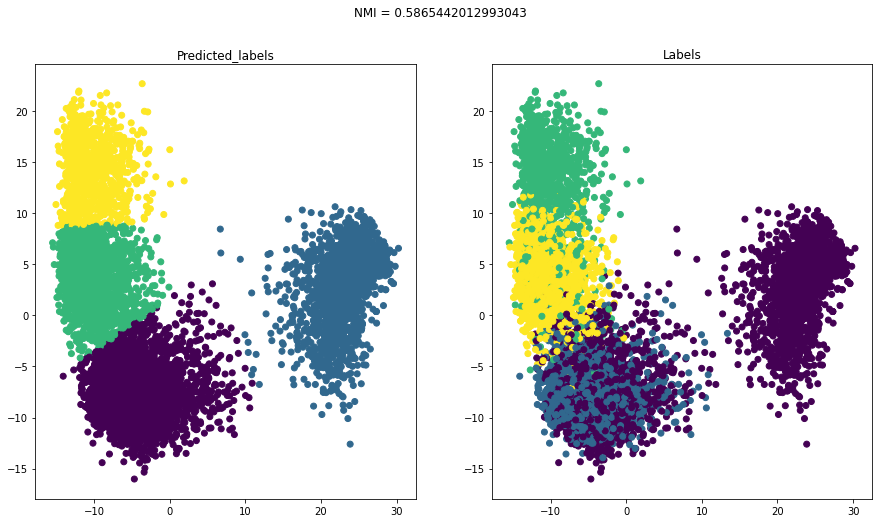

In [ ]:
rkm = fcps.TandemClustering(X_bert, 4, Type='Reduced', PlotIt=False, ndim=2, nstart=10)
pred_labels = rkm[0]
X_bert_reduced = rkm[1][0]
#pred_labels= pred_labels - 1

printMetrics(labels,pred_labels)
eval_clustering_2D(X_bert_reduced,pred_labels,labels)

### Factorial K-means

  |======================================================================| 100%normalized_mutual_info_score:  0.43 %
Accuracy:  0.61 %
Adjusted Rand Index:  0.27 %


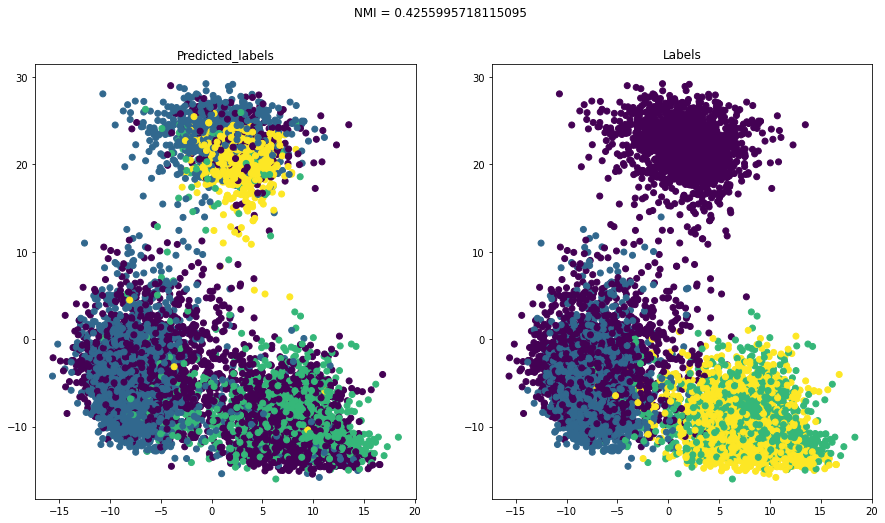

In [ ]:
rkm = fcps.TandemClustering(X_bert, 4, Type='Factorial', PlotIt=False, ndim=2, nstart=10)
pred_labels = rkm[0]
X_bert_reduced = rkm[1][0]
#pred_labels= pred_labels - 1

printMetrics(labels,pred_labels)
eval_clustering_2D(X_bert_reduced,pred_labels,labels)

### Deep K-Means (DKM)

In [ ]:
X_bert_reduced, cluster_assign = DKM(X_bert, 4, 2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:37<00:00,  1.85s/it]


In [ ]:
X_bert_reduced.shape

(7095, 2)

normalized_mutual_info_score:  0.71 %
Accuracy:  0.77 %
Adjusted Rand Index:  0.51 %


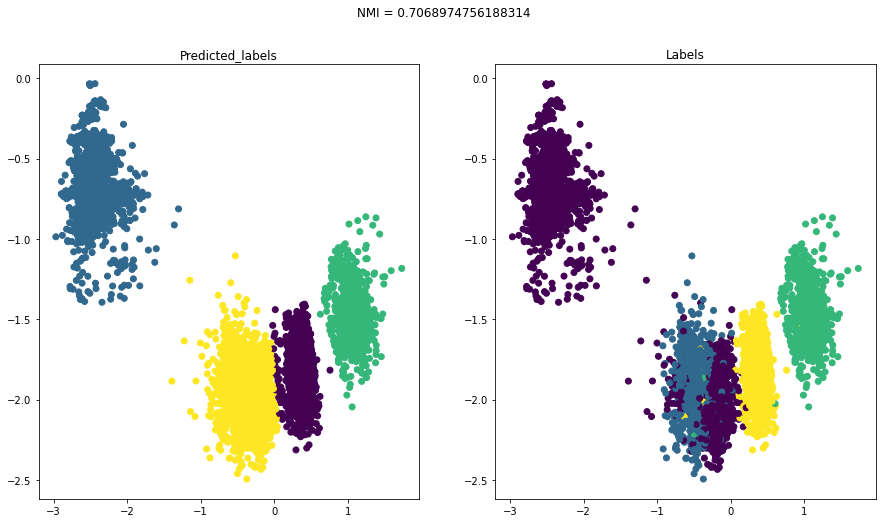

In [ ]:
printMetrics(labels,cluster_assign)
eval_clustering_2D(X_bert_reduced,cluster_assign,labels)

### Deep Clustering Network (DCN)

In [ ]:
tf.reset_default_graph()

In [ ]:
X_bert_reduced, cluster_assign = DCN(X_bert, 4, 2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.23it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:55<00:00,  1.10s/it]


normalized_mutual_info_score:  0.66 %
Accuracy:  0.77 %
Adjusted Rand Index:  0.48 %


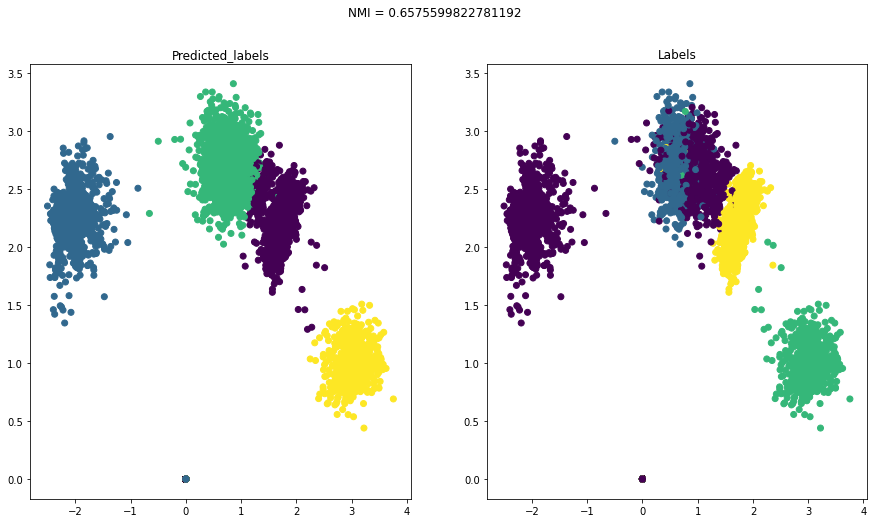

In [ ]:
printMetrics(labels,cluster_assign)
eval_clustering_2D(X_bert_reduced,cluster_assign,labels)

###Comparaison des résultats (approches combinées)

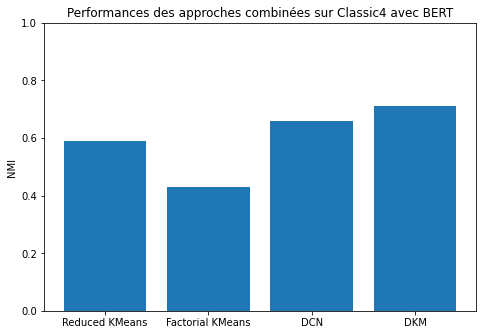

In [ ]:
perfs = [0.59, 0.43, 0.66, 0.71]
compareCombined(perfs, "Performances des approches combinées sur Classic4 avec BERT")

Avec BERT, les approches combinées donnent de plutôt bons résultats, notamment DCN et DKM, mais restent un peu en dessous des meilleurs approches Tandem.

#Roberta

In [ ]:
model_name = 'roberta-base'
model_rob = RobertaModel.from_pretrained(model_name, output_hidden_states=True)
tokenizer_rob = RobertaTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
if device == 'cuda':
  model_rob.cuda()

In [ ]:
roberta_embeddings = encode_sentences_batch(model_rob, tokenizer_rob, texts, batch_size=32)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
roberta_embeddings[11].shape

(7095, 768)

In [ ]:
X_rob = np.array(roberta_embeddings).mean(axis=0)

X_rob.shape

(7095, 768)

## Clustering sur l'espace d'origine

### KMeans

In [ ]:
pred_labels = KMeans(4,random_state=42).fit(X_rob).labels_
printMetrics(labels, pred_labels)

normalized_mutual_info_score:  0.23 %
Accuracy:  0.45 %
Adjusted Rand Index:  0.17 %


### Spectral Clustering

In [ ]:
pred_labels=SpectralClustering(4,affinity='nearest_neighbors',n_neighbors=10,random_state=42).fit(X_rob).labels_
printMetrics(labels, pred_labels)

normalized_mutual_info_score:  0.59 %
Accuracy:  0.72 %
Adjusted Rand Index:  0.4 %


### HDBSCAN

In [ ]:
!pip install hdbscan
import hdbscan

     |████████████████████████████████| 6.4 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311879 sha256=60ba7f079a7dd5a764d16dee47e2c61e7b398de0913c2c0d7eb69932184179e6
  Stored in directory: /root/.cache/pip/wheels/73/5f/2f/9a259b84003b84847c259779206acecabb25ab56f1506ee72b
Successfully built hdbscan


In [ ]:
from sklearn.preprocessing import StandardScaler
X_rob_sc = StandardScaler().fit_transform(X_rob)
#from sklearn.metrics import pairwise_distances
#distance = pairwise_distances(X_bert, metric='cosine')
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=50, metric='braycurtis').fit(X_rob_sc)

#pred_labels = hdbscan_model.fit(distance.astype('float64')).labels_

pred_labels = hdbscan_model.labels_
printMetrics(labels, pred_labels)

normalized_mutual_info_score:  0.27 %
Accuracy:  0.42 %
Adjusted Rand Index:  0.14 %


In [ ]:
np.unique(pred_labels)

array([-1,  0,  1])

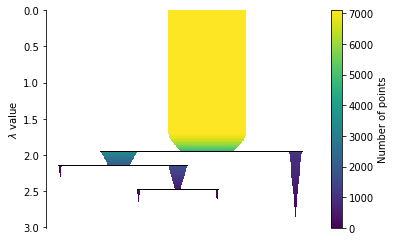

In [ ]:
hdbscan_model.condensed_tree_.plot()

### CAH

In [ ]:
from sklearn.cluster import AgglomerativeClustering

pred_labels = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward').fit(X_rob).labels_
#CAH = AgglomerativeClustering().fit(X_w2v_reduced)
#pred_labels= CAH.labels_
printMetrics(labels, pred_labels)

normalized_mutual_info_score:  0.26 %
Accuracy:  0.46 %
Adjusted Rand Index:  0.14 %


Seul le Spectral Clustering s'en tire de façon convenable avec Roberta.

## Approches Tandem

### PCA 

In [ ]:
X_rob_reduced = PCA(n_components=2, whiten=False, random_state=42).fit_transform(X_rob)

#### PCA + Kmeans 

normalized_mutual_info_score:  0.23 %
Accuracy:  0.47 %
Adjusted Rand Index:  0.18 %


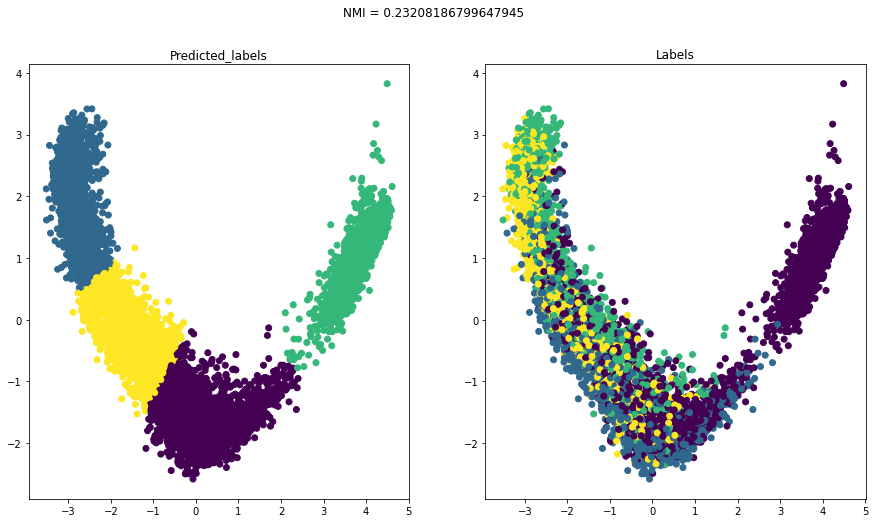

In [ ]:
pred_labels = KMeans(4,random_state=42).fit(X_rob_reduced).labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(X_rob_reduced,pred_labels, labels)

#### PCA + Clustering spectral 

normalized_mutual_info_score:  0.24 %
Accuracy:  0.46 %
Adjusted Rand Index:  0.18 %


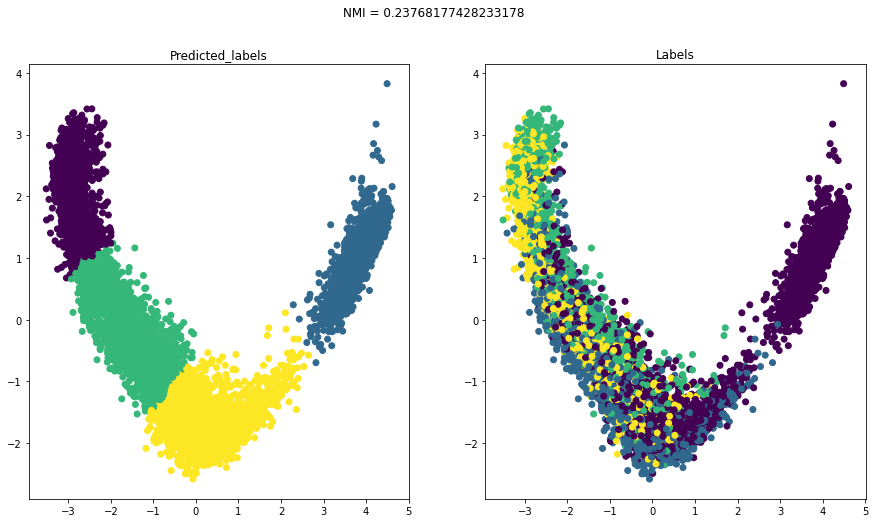

In [ ]:
pred_labels=SpectralClustering(4,affinity='nearest_neighbors',n_neighbors=10,random_state=42).fit(X_rob_reduced).labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(X_rob_reduced,pred_labels, labels)

#### PCA + HDBSCAN

normalized_mutual_info_score:  0.23 %
Accuracy:  0.5 %
Adjusted Rand Index:  0.17 %


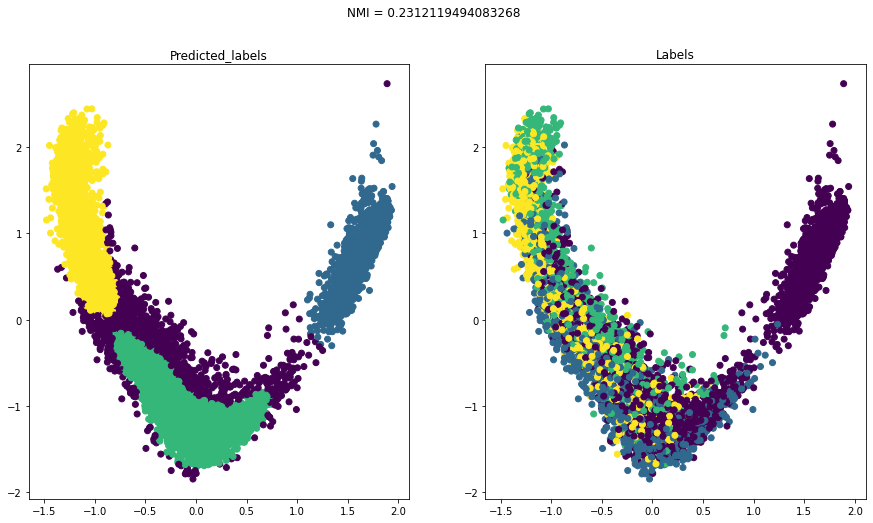

In [ ]:
X_rob_reduced_sc = StandardScaler().fit_transform(X_rob_reduced)
hdbscan_model = hdbscan.HDBSCAN(algorithm= 'best', alpha=1.0, leaf_size=40,min_cluster_size=100, cluster_selection_method='eom', metric='braycurtis').fit(X_rob_reduced_sc)
pred_labels= hdbscan_model.labels_
printMetrics(labels, pred_labels)
eval_clustering_2D(X_rob_reduced_sc,pred_labels, labels)


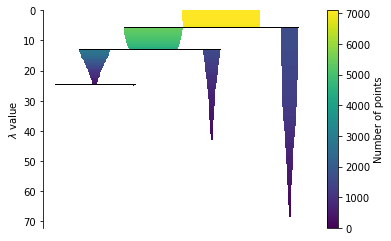

In [ ]:
hdbscan_model.condensed_tree_.plot()

#### PCA + CAH

normalized_mutual_info_score:  0.23 %
Accuracy:  0.48 %
Adjusted Rand Index:  0.18 %


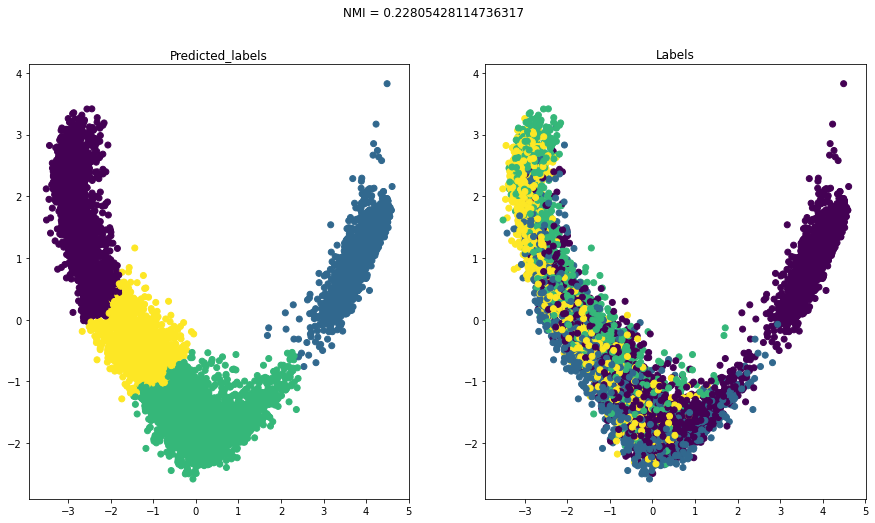

In [ ]:
pred_labels = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward').fit(X_rob_reduced).labels_
printMetrics(labels, pred_labels)
eval_clustering_2D(X_rob_reduced,pred_labels,labels)

### TSNE

In [ ]:
from sklearn.manifold import TSNE
X_rob_reduced = TSNE(n_components=2, random_state=42).fit_transform(X_rob)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


#### TSNE + Kmeans 

normalized_mutual_info_score:  0.45 %
Accuracy:  0.59 %
Adjusted Rand Index:  0.32 %


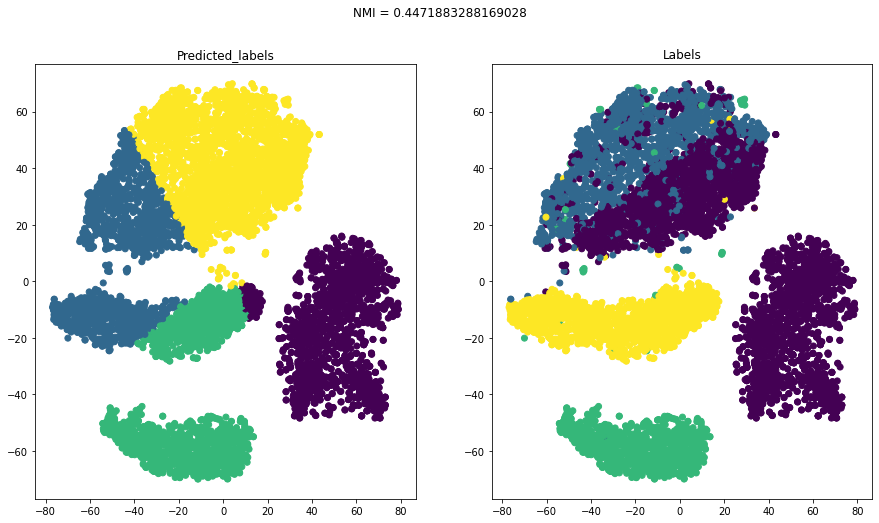

In [ ]:
pred_labels = KMeans(4,random_state=42).fit(X_rob_reduced).labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(X_rob_reduced,pred_labels, labels)

La séparation avec TSNE est correcte, sauf pour un cluster qui se retrouve divisé en 2 (une partie bien séparée des autres points et l'autre collée à un autre cluster). On retrouvait déjà ce schéma avec BERT. Visiblement, les Transformers ont du mal pour bien séparer l'un des clusters.

#### TSNE + Clustering spectral 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


normalized_mutual_info_score:  0.76 %
Accuracy:  0.78 %
Adjusted Rand Index:  0.6 %


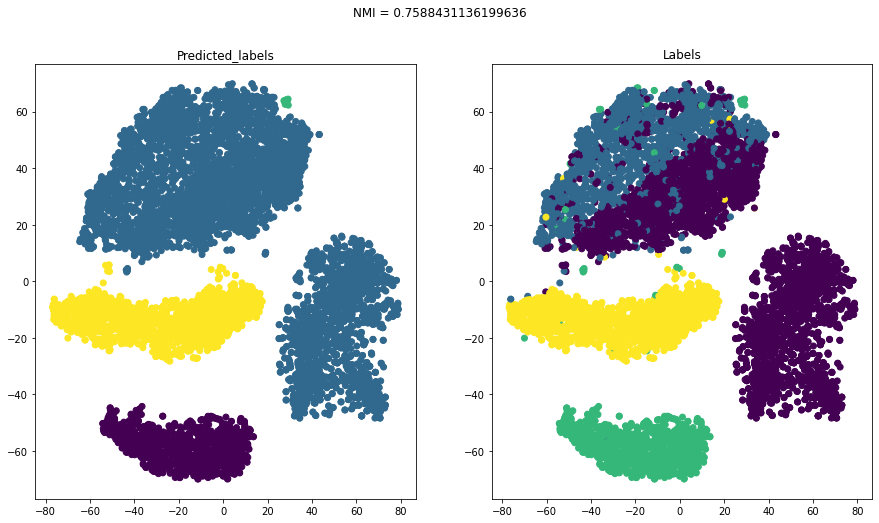

In [ ]:
pred_labels=SpectralClustering(4,affinity='nearest_neighbors',n_neighbors=10,random_state=42).fit(X_rob_reduced).labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(X_rob_reduced,pred_labels, labels)

#### TSNE + HDBSCAN

normalized_mutual_info_score:  0.62 %
Accuracy:  0.68 %
Adjusted Rand Index:  0.43 %


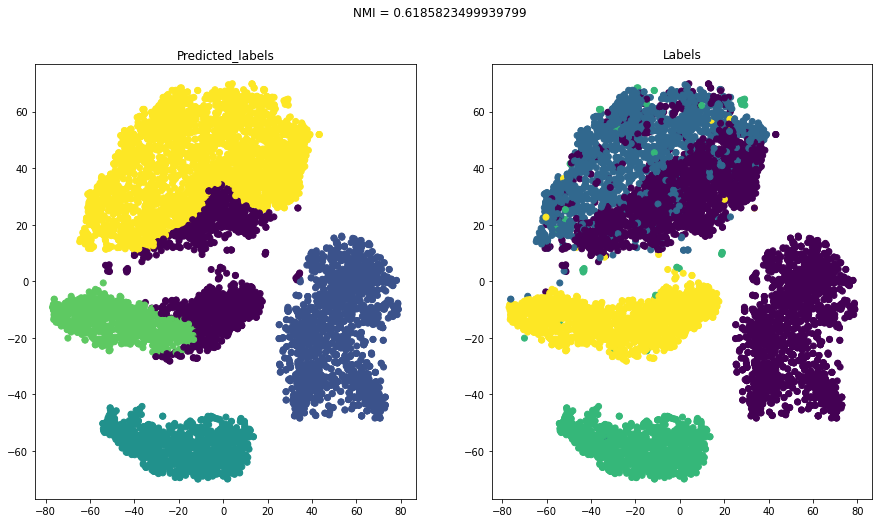

In [ ]:
X_rob_reduced_sc = StandardScaler().fit_transform(X_rob_reduced)
hdbscan_model = hdbscan.HDBSCAN(algorithm= 'best', alpha=1.0, leaf_size=40,min_cluster_size=100, cluster_selection_method='eom', metric='braycurtis').fit(X_rob_reduced_sc)
pred_labels= hdbscan_model.labels_
printMetrics(labels, pred_labels)
eval_clustering_2D(X_rob_reduced,pred_labels, labels)


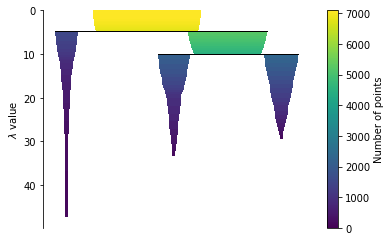

In [ ]:
hdbscan_model.condensed_tree_.plot()

#### TSNE + CAH

normalized_mutual_info_score:  0.49 %
Accuracy:  0.57 %
Adjusted Rand Index:  0.35 %


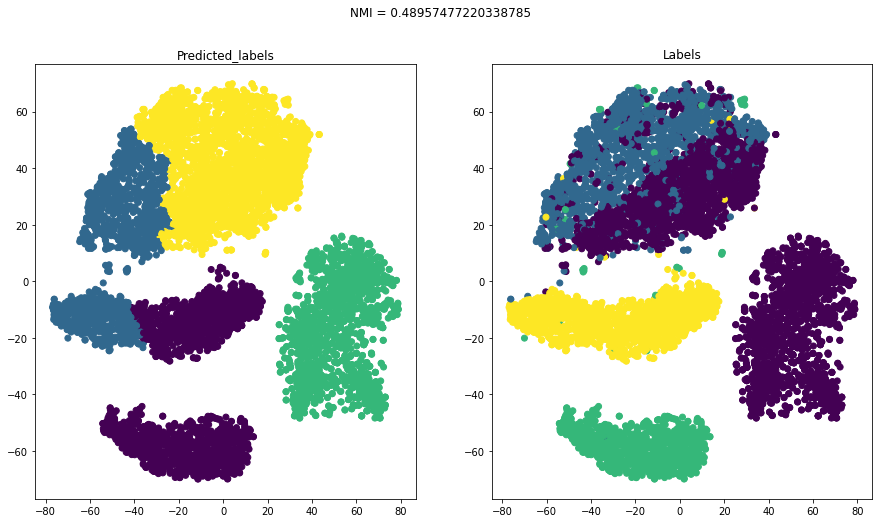

In [ ]:
pred_labels = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward').fit(X_rob_reduced).labels_
printMetrics(labels, pred_labels)
eval_clustering_2D(X_rob_reduced,pred_labels,labels)

### UMAP

In [ ]:
!pip install umap-learn

     |████████████████████████████████| 86 kB 3.2 MB/s 
     |████████████████████████████████| 1.1 MB 38.8 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=91caebf07801c719ac39078e57f67fc480b7af69a11fbc7995e01599c7d81043
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=a39a05420b45de1d3a0782746d810ed1bb22ae56011e8e006e78e11c88623782
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


In [ ]:
from umap import UMAP

X_rob_reduced = UMAP(n_components= 2, random_state=42).fit_transform(X_rob)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


#### UMAP + Kmeans 

normalized_mutual_info_score:  0.72 %
Accuracy:  0.77 %
Adjusted Rand Index:  0.52 %


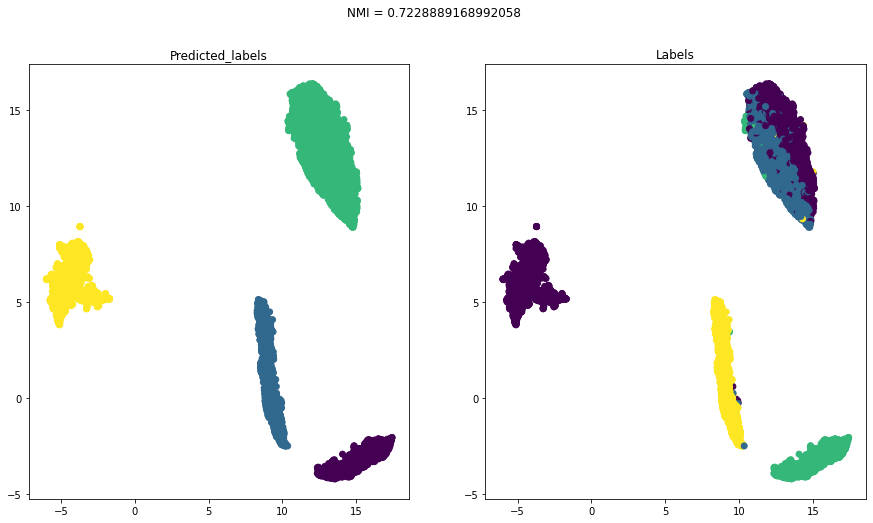

In [ ]:
pred_labels = KMeans(4,random_state=42).fit(X_rob_reduced).labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(X_rob_reduced,pred_labels, labels)

On retrouve ce cluster séparé en 2 dans les vrais clusters, pareil qu'avec TSNE. A part ça, les clusters sont très bien séparés.

#### UMAP + Clustering spectral 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


normalized_mutual_info_score:  0.68 %
Accuracy:  0.69 %
Adjusted Rand Index:  0.54 %


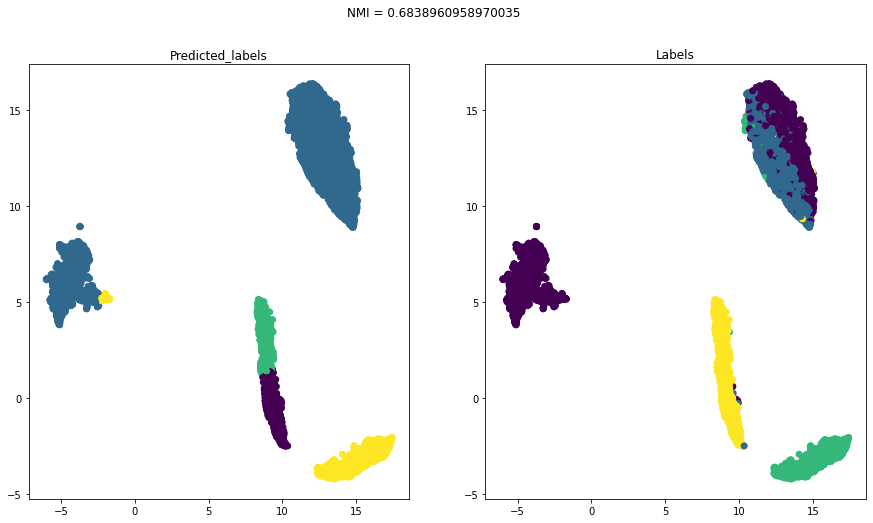

In [ ]:
pred_labels=SpectralClustering(4,affinity='nearest_neighbors',n_neighbors=10,random_state=42).fit(X_rob_reduced).labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(X_rob_reduced,pred_labels, labels)

#### UMAP + HDBSCAN

normalized_mutual_info_score:  0.72 %
Accuracy:  0.76 %
Adjusted Rand Index:  0.51 %


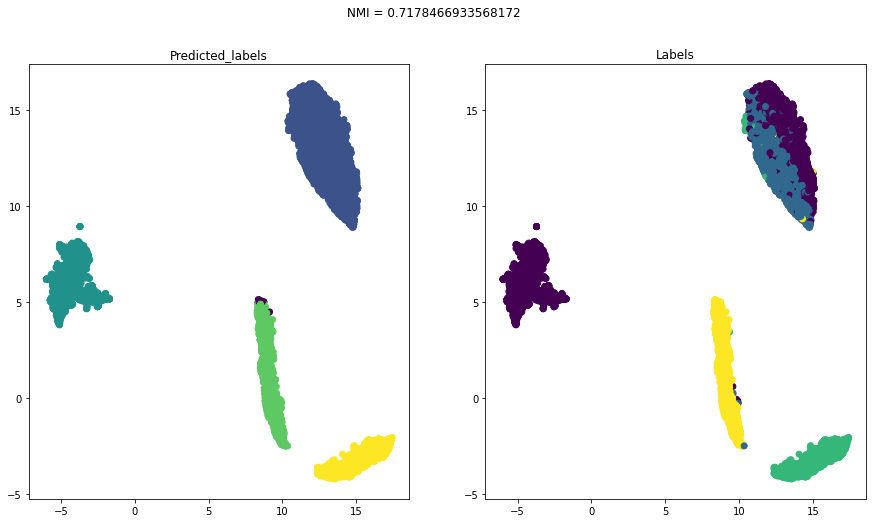

In [ ]:
X_rob_reduced_sc = StandardScaler().fit_transform(X_rob_reduced)
hdbscan_model = hdbscan.HDBSCAN(algorithm= 'best', alpha=1.0, leaf_size=40,min_cluster_size=100, cluster_selection_method='eom', metric='braycurtis').fit(X_rob_reduced_sc)
pred_labels= hdbscan_model.labels_
printMetrics(labels, pred_labels)
eval_clustering_2D(X_rob_reduced,pred_labels, labels)


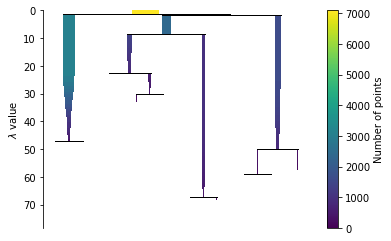

In [ ]:
hdbscan_model.condensed_tree_.plot()

#### UMAP + CAH

normalized_mutual_info_score:  0.72 %
Accuracy:  0.77 %
Adjusted Rand Index:  0.52 %


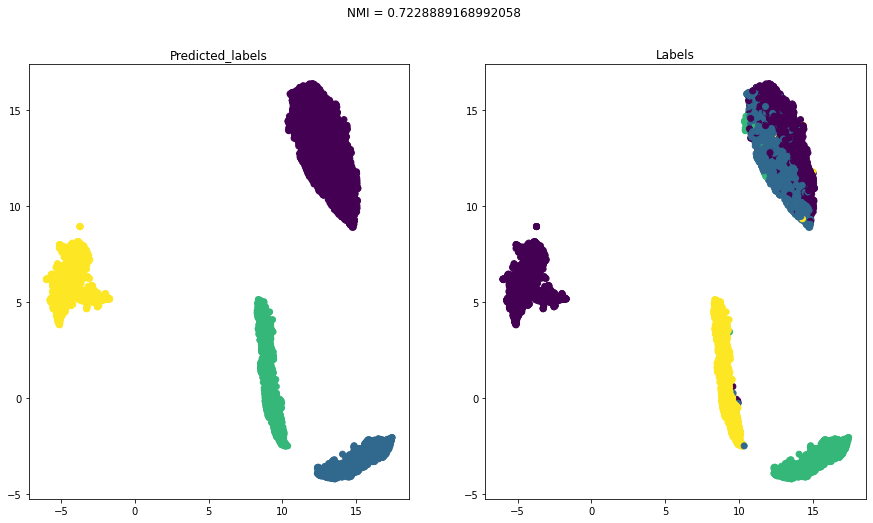

In [ ]:
pred_labels = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward').fit(X_rob_reduced).labels_
printMetrics(labels, pred_labels)
eval_clustering_2D(X_rob_reduced,pred_labels,labels)

### AutoEncoder

In [ ]:
X_rob_reduced = autoencoder(X_rob.astype("float32"), 2, seed=42)

100%|██████████| 50/50 [00:18<00:00,  2.71it/s]


#### AutoEncoder + Kmeans

normalized_mutual_info_score:  0.68 %
Accuracy:  0.77 %
Adjusted Rand Index:  0.5 %


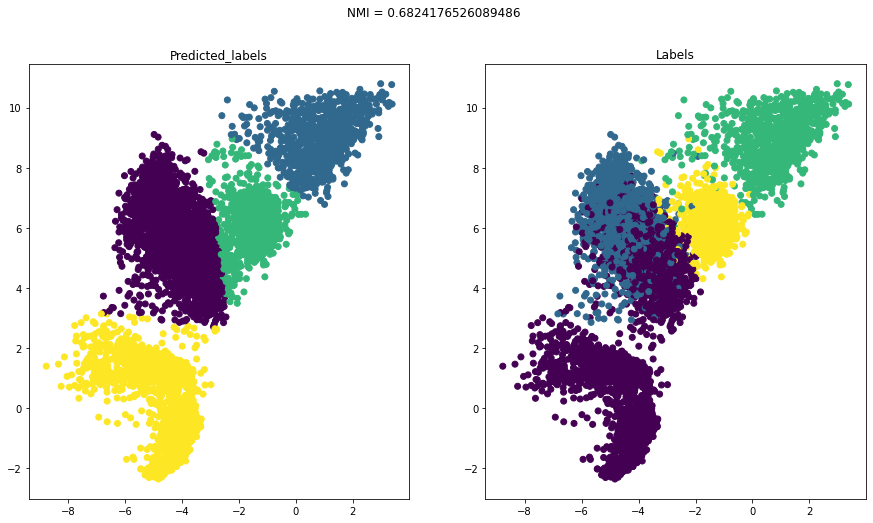

In [ ]:
pred_labels = KMeans(4,random_state=42).fit(X_rob_reduced).labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(X_rob_reduced,pred_labels, labels)

Séparation correcte de l'autoEncoder, hormis toujours ce cluster qui se retrouve divisé en 2.

#### AutoEncoder + Clustering spectral 

normalized_mutual_info_score:  0.65 %
Accuracy:  0.77 %
Adjusted Rand Index:  0.48 %


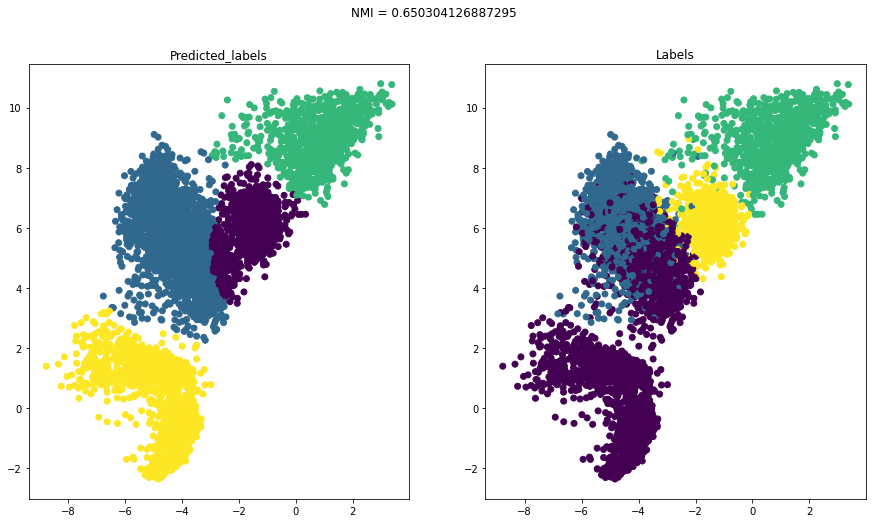

In [ ]:
pred_labels=SpectralClustering(4,affinity='nearest_neighbors',n_neighbors=10,random_state=42).fit(X_rob_reduced).labels_
printMetrics(labels,pred_labels)
eval_clustering_2D(X_rob_reduced,pred_labels, labels)

#### AutoEncoder + HDBSCAN

normalized_mutual_info_score:  0.62 %
Accuracy:  0.7 %
Adjusted Rand Index:  0.47 %


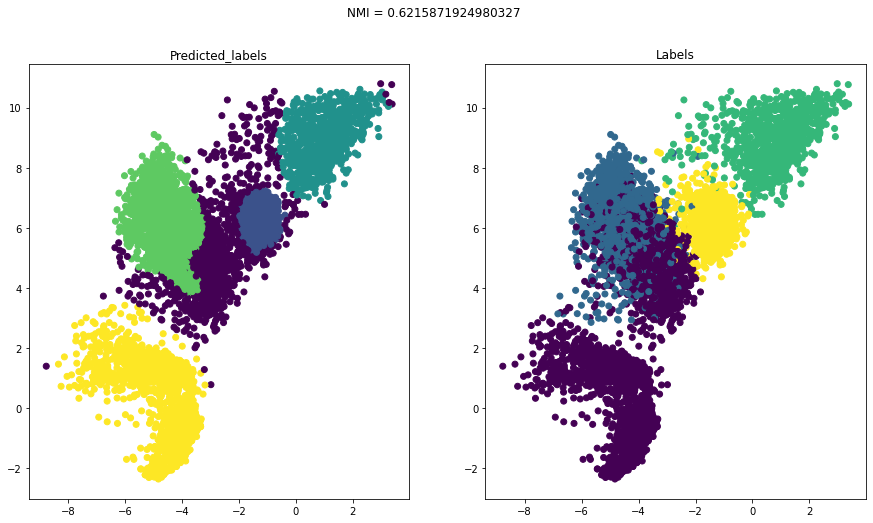

In [ ]:
X_rob_reduced_sc = StandardScaler().fit_transform(X_rob_reduced)
hdbscan_model = hdbscan.HDBSCAN(algorithm= 'best', alpha=1.0, leaf_size=40,min_cluster_size=100, cluster_selection_method='eom', metric='braycurtis').fit(X_rob_reduced_sc)
pred_labels= hdbscan_model.labels_
printMetrics(labels, pred_labels)
eval_clustering_2D(X_rob_reduced,pred_labels, labels)


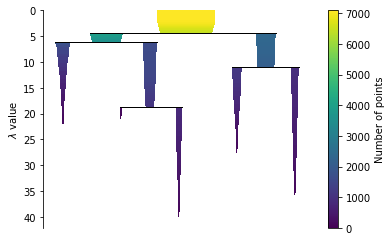

In [ ]:
hdbscan_model.condensed_tree_.plot()

#### AutoEncoder + CAH

normalized_mutual_info_score:  0.71 %
Accuracy:  0.77 %
Adjusted Rand Index:  0.51 %


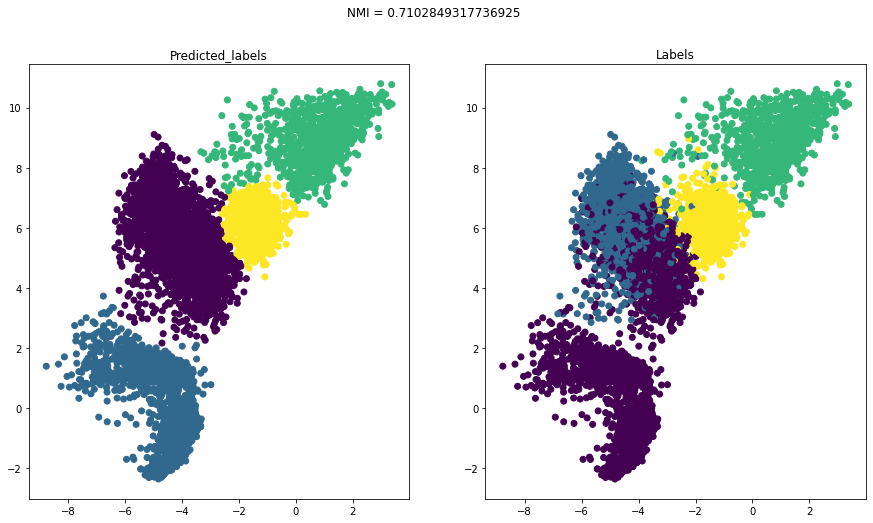

In [ ]:
pred_labels = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward').fit(X_rob_reduced).labels_
printMetrics(labels, pred_labels)
eval_clustering_2D(X_rob_reduced,pred_labels,labels)

### Comparaison des performances (Tandem)

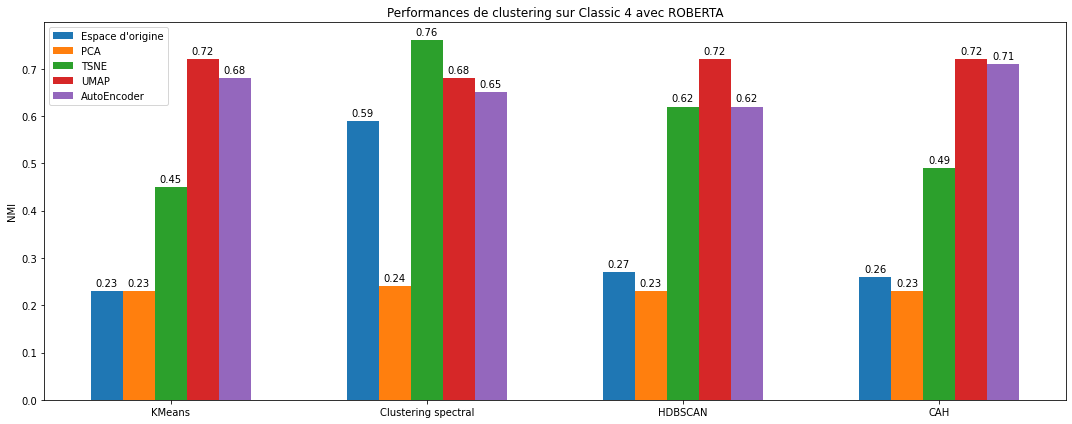

In [ ]:
clust_base = [0.23, 0.59, 0.27, 0.26]
pca_clust = [0.23, 0.24, 0.23, 0.23]
tsne_clust = [0.45, 0.76, 0.62, 0.49]
umap_clust = [0.72, 0.68, 0.72, 0.72]
autoenc_clust = [0.68, 0.65, 0.62, 0.71]
compareNMI(clust_base, pca_clust, tsne_clust, umap_clust, autoenc_clust, "Performances de clustering sur Classic 4 avec ROBERTA")

UMAP reste l'algorithme le plus performant en général, détrôné par TSNE dans un des cas. On notera les bonnes performances de l'autoEncoder avec ROBERTA. Le clustering spectral est le meilleur algorithme de clusterting ici, que ce soit en espace réduit ou sur l'espace d'origine.

## Méthodes combinées

### Code de DKM et DCN

In [ ]:
import os
import math
import numpy as np
import tensorflow.compat.v1 as tf
from sklearn.cluster import KMeans
from tqdm import tqdm

"""
  Credits:
    This code is based on the implementation provided by Maziar Moradi Fard and Thibaut Thonet
    Available in: https://github.com/MaziarMF/deep-k-means
"""

TF_FLOAT_TYPE = tf.float32

tf.disable_eager_execution()

def fc_layers(input, specs):
    [dimensions, activations, names] = specs
    for dimension, activation, name in zip(dimensions, activations, names):
        input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)
    return input

def autoencoder(input, specs):
    [dimensions, activations, names] = specs
    mid_ind = int(len(dimensions)/2)

    # Encoder
    embedding = fc_layers(input, [dimensions[:mid_ind], activations[:mid_ind], names[:mid_ind]])
    # Decoder
    output = fc_layers(embedding, [dimensions[mid_ind:], activations[mid_ind:], names[mid_ind:]])

    return embedding, output

def f_func(x, y):
    return tf.reduce_sum(tf.square(x - y), axis=1)

def g_func(x, y):
    return tf.reduce_sum(tf.square(x - y), axis=1)

def next_batch(num, data):
    """
    Return a total of `num` random samples.
    """
    indices = np.arange(0, data.shape[0])
    np.random.shuffle(indices)
    indices = indices[:num]
    batch_data = np.asarray([data[i, :] for i in indices])

    return indices, batch_data


#######################################################
############### Deep Clustering Network ###############
#######################################################

class DcnCompGraph(object):
    """Computation graph for the Deep Clustering Network model proposed in:
        Yang, B., Fu, X., Sidiropoulos, N. D., & Hong, M. (2017). Towards K-means-friendly Spaces: Simultaneous Deep
        Learning and Clustering. In ICML '17 (pp. 3861–3870).
    This implementation is inspired by https://github.com/boyangumn/DCN
    """

    def __init__(self, ae_specs, n_clusters, batch_size, n_samples, val_lambda):
        input_size = ae_specs[0][-1]
        embedding_size = ae_specs[0][int((len(ae_specs[0]) - 1) / 2)]

        # Placeholder tensor for input data
        self.input = tf.placeholder(dtype=TF_FLOAT_TYPE, shape=(batch_size, input_size))

        # Auto-encoder loss computations
        self.embedding, self.output = autoencoder(self.input, ae_specs)  # Get the auto-encoder's embedding and output
        rec_error = g_func(self.input, self.output)  # Reconstruction error based on distance g
        self.ae_loss = tf.reduce_mean(rec_error)

        # Clustering loss computations
        ## Tensor for cluster representatives
        minval_rep, maxval_rep = -1, 1
        self.cluster_rep = tf.Variable(tf.random_uniform([n_clusters, embedding_size],
                                                    minval=minval_rep, maxval=maxval_rep,
                                                    dtype=TF_FLOAT_TYPE), name='cluster_rep', dtype=TF_FLOAT_TYPE)

        ## Clustering assignments for all samples in the dataset
        initial_clustering_assign = tf.random_uniform(minval=0, maxval=n_clusters, dtype=tf.int32, shape=[n_samples])
        self.cluster_assign = tf.Variable(initial_clustering_assign, name='cluster_assign', dtype=tf.int32, trainable=False)

        ## Get the cluster representative corresponding to the cluster of each batch sample
        self.indices = tf.placeholder(dtype=tf.int32, shape=batch_size)  # Placeholder for sample indices in current batch
        batch_clust_rep = []
        for j in range(batch_size):
            k = self.cluster_assign[self.indices[j]]  # Clustering assignment for sample j in batch
            batch_clust_rep.append(self.cluster_rep[k, :])
        stack_batch_clust_rep = tf.stack(batch_clust_rep)

        ## Compute the k-means term
        clustering_error = f_func(self.embedding, stack_batch_clust_rep)

        # Compute the full loss combining the reconstruction error and k-means term
        self.ae_loss = tf.reduce_mean(rec_error)
        self.kmeans_loss = tf.reduce_mean(clustering_error)
        self.loss = self.ae_loss + val_lambda * self.kmeans_loss

        # The optimizer is defined to minimize this loss
        optimizer = tf.train.AdamOptimizer()
        self.pretrain_op = optimizer.minimize(self.ae_loss) # Pretrain the autoencoder before starting DCN
        self.train_op = optimizer.minimize(self.loss)

        # As it has been pointed out in the DCN paper, first the weights of the autoencoder shall be trained then the
        # assignments and cluster representatives. So far in the computation graph we have optimized the weights of the
        # autoencoder, now it's the time for the assignments and representatives.

        # Update the clustering assignments
        for j in range(batch_size):
            # Find which cluster representative is the closest to the current batch sample
            new_assign = tf.argmin(f_func(tf.reshape(self.embedding[j, :], (1, embedding_size)), self.cluster_rep),
                                   output_type=tf.int32)
            # Update the clustering assignment
            self.cluster_assign_update = tf.assign(self.cluster_assign[self.indices[j]], new_assign)

        # Update the cluster representatives
        ## Initialize the value of count
        initial_count = tf.constant(100.0, shape=[n_clusters])
        count = tf.Variable(initial_count, name='count', dtype=TF_FLOAT_TYPE, trainable=False)
        ## Update the cluster representatives according to Equation (8) in the DCN paper
        for j in range(batch_size):
            k = self.cluster_assign[self.indices[j]]  # Clustering assignment for sample j in batch
            self.count_update = tf.assign(count[k], count[k] + 1)  # Updated count for cluster assignments
            new_rep = self.cluster_rep[k] - (1 / count[k]) * (self.cluster_rep[k] - self.embedding[j])
            self.cluster_rep_update = tf.assign(self.cluster_rep[k], new_rep)

def DCN(data, n_clusters, n_components, n_pretrain_epochs=50, n_finetuning_epochs=50, lambda_=1.0, batch_size=256, seed=None, cpu=False):
    # Auto-encoder architecture
    input_size = data.shape[1]
    hidden_1_size = 500
    hidden_2_size = 500
    hidden_3_size = 2000
    embedding_size = n_components
    dimensions = [hidden_1_size, hidden_2_size, hidden_3_size, embedding_size, # Encoder layer dimensions
                  hidden_3_size, hidden_2_size, hidden_1_size, input_size] # Decoder layer dimensions
    activations = [tf.nn.relu, tf.nn.relu, tf.nn.relu, None, # Encoder layer activations
                  tf.nn.relu, tf.nn.relu, tf.nn.relu, None] # Decoder layer activations
    names = ['enc_hidden_1', 'enc_hidden_2', 'enc_hidden_3', 'embedding', # Encoder layer names
            'dec_hidden_1', 'dec_hidden_2', 'dec_hidden_3', 'output'] # Decoder layer names

    n_samples = data.shape[0]
    n_batches = int(math.ceil(n_samples / batch_size)) # Number of mini-batches
    pretrain = True # Specify if DKM's autoencoder should be pretrained

    # Hardware specifications
    if cpu:
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Run on CPU instead of GPU if batch_size is small
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.05)

    if seed is not None:
      tf.reset_default_graph()
      tf.set_random_seed(seed)
      np.random.seed(seed)

    cg = DcnCompGraph([dimensions, activations, names], n_clusters, batch_size, n_samples,
                      lambda_)

    # Run the computation graph
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        # Initialization
        init = tf.global_variables_initializer()
        sess.run(init)

        # Pretrain if specified
        if pretrain:
            print("Starting autoencoder pretraining...")

            # Variables to save pretraining tensor content
            embeddings = np.zeros((n_samples, embedding_size), dtype=float)

            # First, pretrain the autoencoder
            ## Loop over epochs
            for _ in tqdm(range(n_pretrain_epochs)):

                # Loop over the samples
                for _ in range(n_batches):
                    # Fetch a random data batch of the specified size
                    indices_, data_batch = next_batch(batch_size, data)

                    # Run the computation graph until pretrain_op (only on autoencoder) on the data batch
                    _, embedding_, ae_loss_ = sess.run((cg.pretrain_op, cg.embedding, cg.ae_loss),
                                                       feed_dict={cg.input: data_batch})

                    # Save the embeddings for batch samples
                    for j in range(len(indices_)):
                        embeddings[indices_[j], :] = embedding_[j, :]

            # Second, run k-means++ on the pretrained embeddings
            print("Running k-means on the learned embeddings...")
            kmeans_model = KMeans(n_clusters=n_clusters, init="k-means++").fit(embeddings)

            # The cluster centers are used to initialize the cluster representatives in DCN
            sess.run(tf.assign(cg.cluster_rep, kmeans_model.cluster_centers_))

            # The clustering assignments are used to initialize the clustering assignments in DCN
            sess.run(tf.assign(cg.cluster_assign, kmeans_model.labels_))

        # Train the full DCN model
        print("Starting DCN training...")
        ## Loop over epochs
        for epoch in tqdm(range(n_finetuning_epochs)):
            # print("Training step: epoch {}".format(epoch))

            # Loop over the samples
            for _ in range(n_batches):
                # Fetch a random data batch of the specified size
                indices_, data_batch = next_batch(batch_size, data)

                # Run the computation graph on the data batch
                _, _, _, _, loss_, cluster_assign_, ae_loss_, kmeans_loss_ =\
                    sess.run((cg.train_op, cg.cluster_assign_update, cg.count_update, cg.cluster_rep_update, cg.loss,
                              cg.cluster_assign, cg.ae_loss, cg.kmeans_loss),
                             feed_dict={cg.input: data_batch, cg.indices: indices_})
        
        embeddings = np.zeros((n_samples, embedding_size), dtype=float)
        for _ in range(n_batches):
            # Fetch a random data batch of the specified size
            indices_, data_batch = next_batch(batch_size, data)

            # Run the computation graph on the data batch
            _, _, embeddings_, _, _, loss_, cluster_assign_, ae_loss_, kmeans_loss_ =\
                sess.run((cg.train_op, cg.cluster_assign_update, cg.embedding, cg.count_update, cg.cluster_rep_update, cg.loss,
                          cg.cluster_assign, cg.ae_loss, cg.kmeans_loss),
                          feed_dict={cg.input: data_batch, cg.indices: indices_})

            for j in range(len(indices_)):
                embeddings[indices_[j], :] = embeddings_[j, :]
                
    return embeddings, cluster_assign_


#######################################################
##################### Deep K-means ####################
#######################################################

class DkmCompGraph(object):
    """Computation graph for Deep K-Means
    """

    def __init__(self, ae_specs, n_clusters, val_lambda):
        input_size = ae_specs[0][-1]
        embedding_size = ae_specs[0][int((len(ae_specs[0])-1)/2)]

        # Placeholder tensor for input data
        self.input = tf.placeholder(dtype=TF_FLOAT_TYPE, shape=(None, input_size))

        # Auto-encoder loss computations
        self.embedding, self.output = autoencoder(self.input, ae_specs)  # Get the auto-encoder's embedding and output
        rec_error = g_func(self.input, self.output)  # Reconstruction error based on distance g

        # k-Means loss computations
        ## Tensor for cluster representatives
        minval_rep, maxval_rep = -1, 1
        self.cluster_rep = tf.Variable(tf.random_uniform([n_clusters, embedding_size],
                                                    minval=minval_rep, maxval=maxval_rep,
                                                    dtype=TF_FLOAT_TYPE), name='cluster_rep', dtype=TF_FLOAT_TYPE)

        ## First, compute the distance f between the embedding and each cluster representative
        list_dist = []
        for i in range(0, n_clusters):
            dist = f_func(self.embedding, tf.reshape(self.cluster_rep[i, :], (1, embedding_size)))
            list_dist.append(dist)
        self.stack_dist = tf.stack(list_dist)

        ## Second, find the minimum squared distance for softmax normalization
        min_dist = tf.reduce_min(list_dist, axis=0)

        ## Third, compute exponentials shifted with min_dist to avoid underflow (0/0) issues in softmaxes
        self.alpha = tf.placeholder(dtype=TF_FLOAT_TYPE, shape=())  # Placeholder tensor for alpha
        list_exp = []
        for i in range(n_clusters):
            exp = tf.exp(-self.alpha * (self.stack_dist[i] - min_dist))
            list_exp.append(exp)
        stack_exp = tf.stack(list_exp)
        sum_exponentials = tf.reduce_sum(stack_exp, axis=0)

        ## Fourth, compute softmaxes and the embedding/representative distances weighted by softmax
        list_softmax = []
        list_weighted_dist = []
        for j in range(n_clusters):
            softmax = stack_exp[j] / sum_exponentials
            weighted_dist = self.stack_dist[j] * softmax
            list_softmax.append(softmax)
            list_weighted_dist.append(weighted_dist)
        stack_weighted_dist = tf.stack(list_weighted_dist)

        # Compute the full loss combining the reconstruction error and k-means term
        self.ae_loss = tf.reduce_mean(rec_error)
        self.kmeans_loss = tf.reduce_mean(tf.reduce_sum(stack_weighted_dist, axis=0))
        self.loss = self.ae_loss + val_lambda * self.kmeans_loss

        # The optimizer is defined to minimize this loss
        optimizer = tf.train.AdamOptimizer()
        self.pretrain_op = optimizer.minimize(self.ae_loss) # Pretrain the autoencoder before starting DKM
        self.train_op = optimizer.minimize(self.loss) # Train the whole DKM model

def DKM(data, n_clusters, n_components, n_pretrain_epochs=50, n_finetuning_epochs=5, lambda_=1.0, batch_size=256, seed=None, cpu=False):
    """
        The final number of finetuning epochs is n_finetuning_epochs * 20 if pretrain and n_finetuning_epochs * 40 if annealing
    """
    # Auto-encoder architecture
    input_size = data.shape[1]
    hidden_1_size = 500
    hidden_2_size = 500
    hidden_3_size = 2000
    embedding_size = n_components
    dimensions = [hidden_1_size, hidden_2_size, hidden_3_size, embedding_size, # Encoder layer dimensions
                  hidden_3_size, hidden_2_size, hidden_1_size, input_size] # Decoder layer dimensions
    activations = [tf.nn.relu, tf.nn.relu, tf.nn.relu, None, # Encoder layer activations
                  tf.nn.relu, tf.nn.relu, tf.nn.relu, None] # Decoder layer activations
    names = ['enc_hidden_1', 'enc_hidden_2', 'enc_hidden_3', 'embedding', # Encoder layer names
            'dec_hidden_1', 'dec_hidden_2', 'dec_hidden_3', 'output'] # Decoder layer names

    n_samples = data.shape[0]
    n_batches = int(math.ceil(n_samples / batch_size)) # Number of mini-batches
    pretrain = True # Specify if DKM's autoencoder should be pretrained
    annealing = False # Specify if annealing should be used

    # Define the alpha scheme depending on if the approach includes annealing/pretraining
    if annealing and not pretrain:
        constant_value = 1  # specs.embedding_size # Used to modify the range of the alpha scheme
        max_n = 40  # Number of alpha values to consider
        alphas = np.zeros(max_n, dtype=float)
        alphas[0] = 0.1
        for i in range(1, max_n):
            alphas[i] = (2 ** (1 / (np.log(i + 1)) ** 2)) * alphas[i - 1]
        alphas = alphas / constant_value
    elif not annealing and pretrain:
        constant_value = 1  # specs.embedding_size # Used to modify the range of the alpha scheme
        max_n = 20  # Number of alpha values to consider (constant values are used here)
        alphas = 1000*np.ones(max_n, dtype=float) # alpha is constant
        alphas = alphas / constant_value
    else:
        raise Exception("Run with either annealing (-a) or pretraining (-p), but not both.")

    # Hardware specifications
    if cpu:
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Run on CPU instead of GPU if batch_size is small

    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.05)
    config = tf.ConfigProto(gpu_options=gpu_options)

    if seed is not None:
      tf.reset_default_graph()
      tf.set_random_seed(seed)
      np.random.seed(seed)
      
    # Define the computation graph for DKM
    cg = DkmCompGraph([dimensions, activations, names], n_clusters, lambda_)

    # Run the computation graph
    with tf.Session(config=config) as sess:
        # Initialization
        init = tf.global_variables_initializer()
        sess.run(init)

        # Variables to save tensor content
        distances = np.zeros((n_clusters, n_samples))

        # Pretrain if specified
        if pretrain:
            print("Starting autoencoder pretraining...")

            # Variables to save pretraining tensor content
            embeddings = np.zeros((n_samples, embedding_size), dtype=float)

            # First, pretrain the autoencoder
            ## Loop over epochs
            for _ in tqdm(range(n_pretrain_epochs)):
                # Loop over the samples
                for _ in range(n_batches):
                    # Fetch a random data batch of the specified size
                    indices, data_batch = next_batch(batch_size, data)

                    # Run the computation graph until pretrain_op (only on autoencoder) on the data batch
                    _, embedding_, ae_loss_ = sess.run((cg.pretrain_op, cg.embedding, cg.ae_loss),
                                                        feed_dict={cg.input: data_batch})

                    # Save the embeddings for batch samples
                    for j in range(len(indices)):
                        embeddings[indices[j], :] = embedding_[j, :]

            # Second, run k-means++ on the pretrained embeddings
            print("Running k-means on the learned embeddings...")
            kmeans_model = KMeans(n_clusters=n_clusters, init="k-means++").fit(embeddings)

            # The cluster centers are used to initialize the cluster representatives in DKM
            sess.run(tf.assign(cg.cluster_rep, kmeans_model.cluster_centers_))

        # Train the full DKM model
        if (len(alphas) > 0):
            print("Starting DKM training...")
        ## Loop over alpha (inverse temperature), from small to large values
        for k in tqdm(range(len(alphas))):
            # Loop over epochs per alpha
            for _ in range(n_finetuning_epochs):
                # Loop over the samples
                for _ in range(n_batches):
                    # Fetch a random data batch of the specified size
                    indices, data_batch = next_batch(batch_size, data)

                    # Run the computation graph on the data batch
                    _, loss_, stack_dist_, cluster_rep_, ae_loss_, kmeans_loss_ =\
                        sess.run((cg.train_op, cg.loss, cg.stack_dist, cg.cluster_rep, cg.ae_loss, cg.kmeans_loss),
                                  feed_dict={cg.input: data_batch, cg.alpha: alphas[k]})

                    # Save the distances for batch samples
                    for j in range(len(indices)):
                        distances[:, indices[j]] = stack_dist_[:, j]

        _, loss_, X_reduced, stack_dist_, cluster_rep_, ae_loss_, kmeans_loss_ =\
        sess.run((cg.train_op, cg.loss, cg.embedding, cg.stack_dist, cg.cluster_rep, cg.ae_loss, cg.kmeans_loss),
                  feed_dict={cg.input: data, cg.alpha: alphas[k]})

        distances = stack_dist_

        # Infer cluster assignments for all samples
        cluster_assign = np.zeros((n_samples), dtype=float)
        for i in range(n_samples):
            index_closest_cluster = np.argmin(distances[:, i])
            cluster_assign[i] = index_closest_cluster
        cluster_assign = cluster_assign.astype(np.int64)

    return X_reduced, cluster_assign

### Reduced K-means

In [ ]:
!pip install rpy2

In [ ]:
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
from rpy2.robjects.packages import importr
utils = importr('utils')
utils.install_packages('FCPS', repos="https://cloud.r-project.org")
base = importr('base')
fcps = importr('FCPS')
utils.install_packages('clustrd')

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘plyr’, ‘sp’, ‘pracma’, ‘reshape2’, ‘RcppArmadillo’, ‘mclust’, ‘DataVisualizations’


R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/plyr_1.8.6.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 401191 bytes (391 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wr

<rpy2.rinterface_lib.sexp.NULLType object at 0x7f11a3753af0> [RTYPES.NILSXP]

R[write to console]: Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



  |======================================================================| 100%normalized_mutual_info_score:  0.51 %
Accuracy:  0.53 %
Adjusted Rand Index:  0.31 %


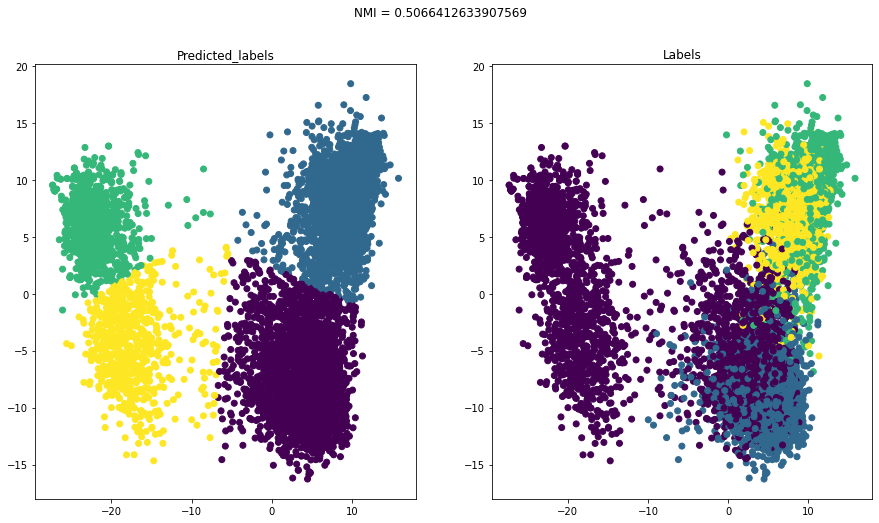

In [ ]:
rkm = fcps.TandemClustering(X_rob, 4, Type='Reduced', PlotIt=False, ndim=2, nstart=10)
pred_labels = rkm[0]
X_rob_reduced = rkm[1][0]
#pred_labels= pred_labels - 1

printMetrics(labels,pred_labels)
eval_clustering_2D(X_rob_reduced,pred_labels,labels)

### Factorial K-means

  |======================================================================| 100%normalized_mutual_info_score:  0.35 %
Accuracy:  0.46 %
Adjusted Rand Index:  0.2 %


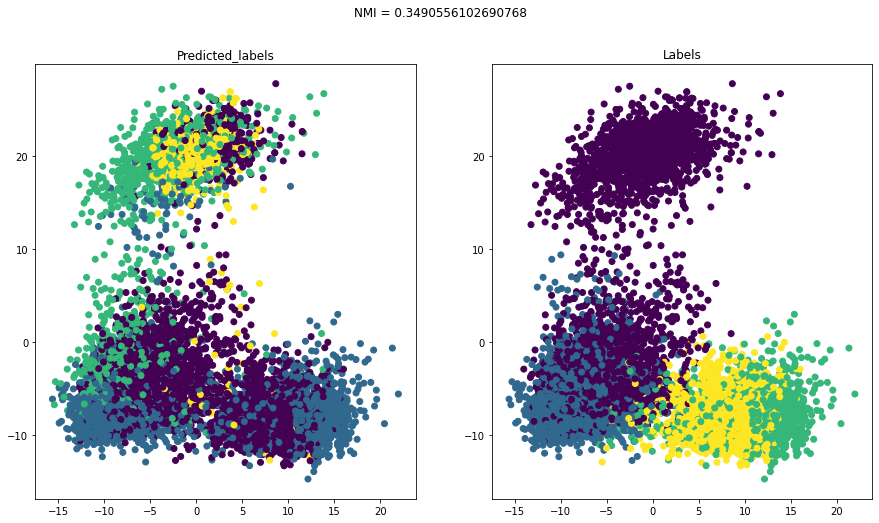

In [ ]:
rkm = fcps.TandemClustering(X_rob, 4, Type='Factorial', PlotIt=False, ndim=2, nstart=10)
pred_labels = rkm[0]
X_rob_reduced = rkm[1][0]
#pred_labels= pred_labels - 1

printMetrics(labels,pred_labels)
eval_clustering_2D(X_rob_reduced,pred_labels,labels)

### Deep K-Means (DKM)

In [ ]:
X_rob_reduced, cluster_assign = DKM(X_rob, 4, 2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:33<00:00,  1.67s/it]


In [ ]:
X_rob_reduced.shape

(7095, 2)

normalized_mutual_info_score:  0.22 %
Accuracy:  0.38 %
Adjusted Rand Index:  0.06 %


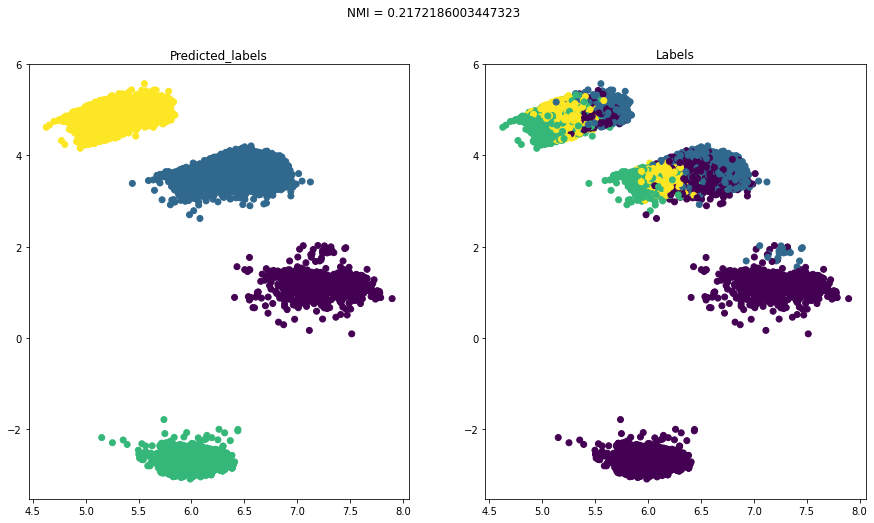

In [ ]:
printMetrics(labels,cluster_assign)
eval_clustering_2D(X_rob_reduced,cluster_assign,labels)

### Deep Clustering Network (DCN)

In [ ]:
tf.reset_default_graph()

In [ ]:
X_rob_reduced, cluster_assign = DCN(X_rob, 4, 2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


normalized_mutual_info_score:  0.21 %
Accuracy:  0.38 %
Adjusted Rand Index:  0.06 %


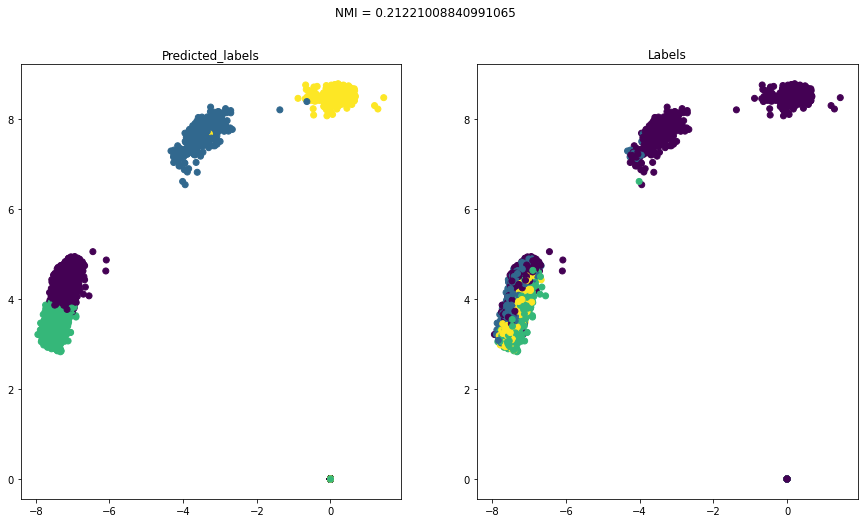

In [ ]:
printMetrics(labels,cluster_assign)
eval_clustering_2D(X_rob_reduced,cluster_assign,labels)

### Comparaison des résultats (approches combinées)

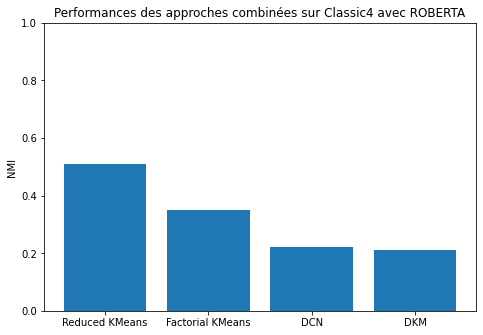

In [ ]:
perfs = [0.51, 0.35, 0.22, 0.21]
compareCombined(perfs, "Performances des approches combinées sur Classic4 avec ROBERTA")

Les approches combinées ne donnent pas de bons résultats avec ROBERTA, sauf Reduced KMeans qui s'en sort un peu mieux.

# Conclusion

Sur ce jeu de données, avec un embedding Transformers, UMAP reste le meilleur algorithme de réduction de dimension.

Pour ce qui est du clustering, les résultats sont plus équilibrés. KMeans, Clustering spectral et CAH s'en sortent tous bien selon les cas. HDBSCAN reste mauvais.

Les approches combinées ne sont pas aussi performantes que les meilleures approches Tandem.

L'embedding de ROBERTA est globalement de moins bonne qualité que celui de BERT pour faire du clustering.